# README

* Carpeta de Google Drive donde están los conjuntos de datos: https://drive.google.com/drive/folders/1VFWrzW4QOI8OyEu7Xf3Lfp9DzSD6Ma9s

* Explicación detallado en el PDF, aquí está la ejecución y la lógica del código

# Predicción de Avalanchas con LSTM

In [1]:
# ==========================================
# LIBRERÍAS
# ==========================================
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

# FUNCIONES Y CLASES COMUNES

In [ ]:
# ==========================================
# CONFIGURACIÓN Y CLASES COMUNES
# ==========================================

# Configuración de semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Detección de Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizando dispositivo: {device}")

# ==========================================
# CLASES DE DATASET
# ==========================================

class AvalancheDataset(Dataset):
    """Clase personalizada para carga eficiente de datos en PyTorch"""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ==========================================
# FUNCIONES DE UTILIDAD
# ==========================================

def weighted_mse_loss(input, target, threshold=0.05, weight_factor=10.0):
    """
    Función de pérdida ponderada en PyTorch.
    Penaliza más si el valor real (target) supera el umbral.
    """
    loss = (input - target) ** 2
    mask = (target > threshold).float()
    weights = 1.0 + (weight_factor * mask)
    return torch.mean(loss * weights)

def create_dataset_multi(dataset, look_back=7):
    """Crea ventanas deslizantes (numpy)"""
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0]) 
    return np.array(X), np.array(Y)

def create_sequences(data, seq_length):
    """Crea secuencias temporales (alternativa a create_dataset_multi)"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

def inverse_transform_target(pred_log_scaled, scaler, n_features):
    """Des-normalización y transformación inversa logarítmica"""
    dummy = np.zeros((len(pred_log_scaled), n_features))
    dummy[:, 0] = pred_log_scaled.flatten()
    inv_scale = scaler.inverse_transform(dummy)[:, 0]
    original_scale = np.maximum(0, np.expm1(inv_scale))
    return original_scale

# ==========================================
# FUNCIÓN DE ENTRENAMIENTO GENÉRICA
# ==========================================

def train_model(model, train_loader, val_loader, epochs=40, lr=0.001, model_type='lstm', patience=10):
     # lstm
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    early_stopping_limit = patience
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    counter = 0
    best_model_state = None
    
    print(f"Iniciando entrenamiento {model_type.upper()}...")
    
    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        batch_losses = []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = weighted_mse_loss(y_pred, y_batch)
            loss.backward()
            
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            batch_losses.append(loss.item())
            
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)
        
        # Validación
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_pred = model(X_val)
                v_loss = weighted_mse_loss(val_pred, y_val)
                val_batch_losses.append(v_loss.item())
        
        avg_val_loss = np.mean(val_batch_losses)
        val_losses.append(avg_val_loss)
        
        # Logging
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}")
            
        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1
            if counter >= early_stopping_limit:
                print(f"Early stopping activado en epoch {epoch+1}")
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break
                
    return train_losses, val_losses

#Modelo LSTM de base
class AvalancheLSTM(nn.Module):
    """Arquitectura LSTM para predicción de avalanchas"""
    def __init__(self, input_size, hidden_layer_1=64, hidden_layer_2=32, output_size=1):
        super(AvalancheLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_layer_1, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        self.lstm2 = nn.LSTM(hidden_layer_1, hidden_layer_2, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_layer_2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_size)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, (hn, cn) = self.lstm2(out)
        last_step = hn[-1]
        out = self.dropout2(last_step)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

Utilizando dispositivo: cpu


# TESTEO HIPERPARAMETROS

Vamos a hacer una breve comparativo sobre que parámetros vamos a usar para nuestra red, con un equilibrio entre sencillez y eficacia


=== Config: {'h1': 8, 'h2': 8} ===
Iniciando entrenamiento LSTM...
Epoch 5/30 | Train Loss: 0.12809 | Val Loss: 0.16833
Epoch 10/30 | Train Loss: 0.12038 | Val Loss: 0.15949
Epoch 15/30 | Train Loss: 0.11624 | Val Loss: 0.15187
Epoch 20/30 | Train Loss: 0.11333 | Val Loss: 0.14772
Epoch 25/30 | Train Loss: 0.11429 | Val Loss: 0.14516
Epoch 30/30 | Train Loss: 0.11203 | Val Loss: 0.14255
RMSE: 11.2170 | MAE: 3.0211

=== Config: {'h1': 16, 'h2': 16} ===
Iniciando entrenamiento LSTM...
Epoch 5/30 | Train Loss: 0.12430 | Val Loss: 0.16465
Epoch 10/30 | Train Loss: 0.11669 | Val Loss: 0.15591
Epoch 15/30 | Train Loss: 0.11473 | Val Loss: 0.15014
Epoch 20/30 | Train Loss: 0.11032 | Val Loss: 0.14607
Epoch 25/30 | Train Loss: 0.11036 | Val Loss: 0.14465
Epoch 30/30 | Train Loss: 0.10990 | Val Loss: 0.14220
RMSE: 11.1585 | MAE: 3.1086

=== Config: {'h1': 64, 'h2': 32} ===
Iniciando entrenamiento LSTM...
Epoch 5/30 | Train Loss: 0.11742 | Val Loss: 0.15727
Epoch 10/30 | Train Loss: 0.11020 | V

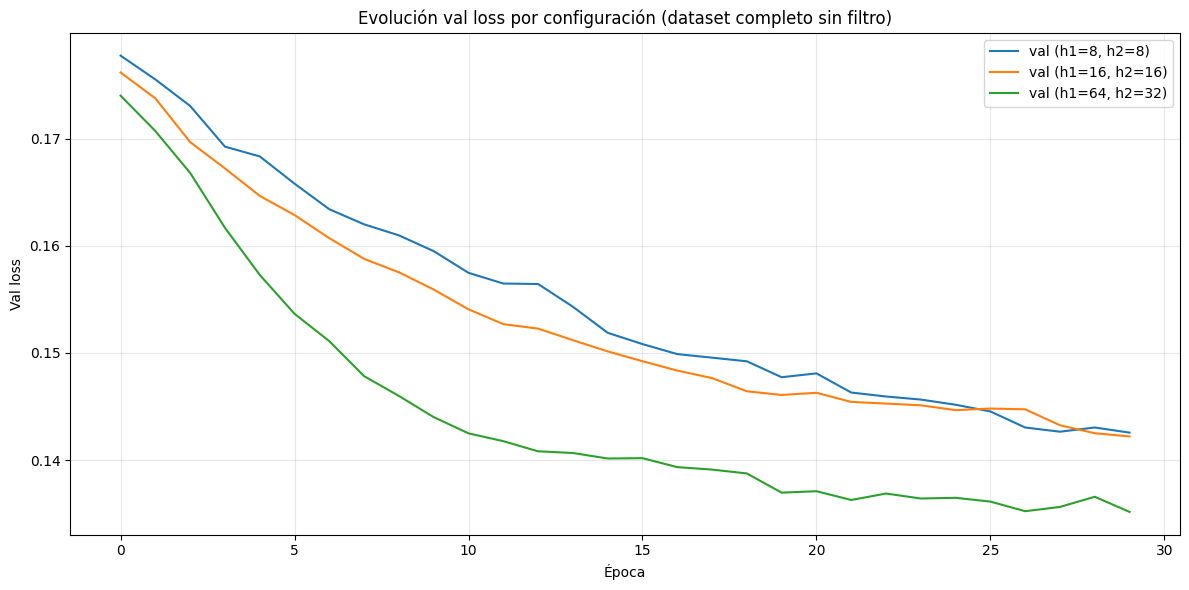

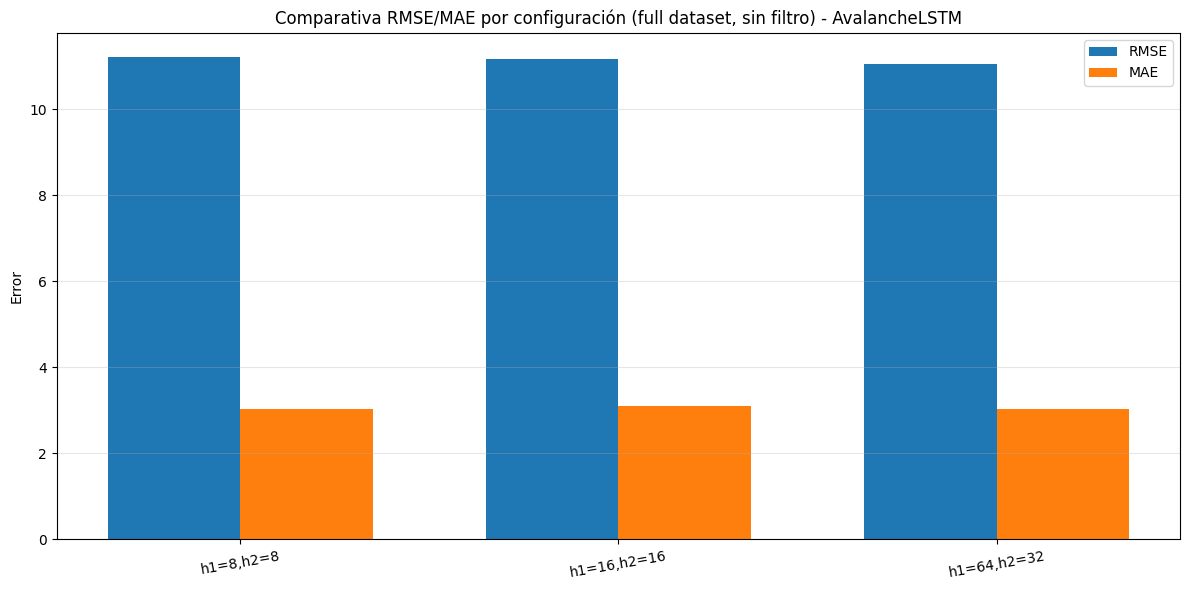

In [16]:
# ==========================================
# SONDEO DE HIPERPARÁMETROS (LSTM estándar, SIN FILTRO ESTACIONAL)
# ==========================================

#configuraciones a probar
hparam_configs = [
    {"h1": 8,  "h2": 8},
    {"h1": 16,  "h2": 16},
    {"h1": 64, "h2": 32},
]

EPOCHS_HP = 30
LOOK_BACK_HP = 7

# Cargar dataset completo sin filtro estacional
def load_full_no_filter():
    df_obs = pd.read_csv('data_set_1_avalanche_observations_wi9899_to_wi1819_davos.csv', delimiter=';')
    df_daily = pd.read_csv('data_set_2_danger_avalanches.csv', delimiter=';')
    df_weather = pd.read_csv('davos_weather_1998_2019.csv', delimiter=';')

    df_obs['date_release'] = pd.to_datetime(df_obs['date_release'])
    df_daily['date'] = pd.to_datetime(df_daily['date'])
    df_weather['date'] = pd.to_datetime(df_weather['date'])

    df_obs_daily = df_obs.groupby('date_release').agg({
        'max_elevation_m': 'mean',
        'area_m2': 'sum'
    }).reset_index().rename(columns={'date_release': 'date'})

    df = pd.merge(df_daily[['date', 'AAI_all', 'max.danger.corr']], df_weather, on='date', how='inner')
    df = pd.merge(df, df_obs_daily, on='date', how='left')

    df['AAI_all'] = df['AAI_all'].fillna(0)
    df['area_m2'] = df['area_m2'].fillna(0)
    df['max_elevation_m'] = df['max_elevation_m'].fillna(0)
    df['max.danger.corr'] = df['max.danger.corr'].ffill().fillna(1)

    df['log_AAI'] = np.log1p(df['AAI_all'])
    df['snow_3d'] = df['snowfall'].rolling(window=3).sum().fillna(0)

    # Sin filtro de meses
    df = df.sort_values('date').reset_index(drop=True)

    features_hp = ['log_AAI', 'max.danger.corr', 'temp_mean', 'snowfall', 'wind_speed', 'max_elevation_m', 'area_m2', 'snow_3d']
    return df, features_hp

def prepare_full_no_filter():
    df_full, feature_cols_hp = load_full_no_filter()
    data = df_full[feature_cols_hp].values
    scaler_hp = MinMaxScaler()
    data_scaled = scaler_hp.fit_transform(data)
    X, y = create_sequences(data_scaled, LOOK_BACK_HP)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    return X_train, X_test, y_train, y_test, scaler_hp, feature_cols_hp

# Entrenar y evaluar una config con AvalancheLSTM
def train_eval_config(cfg):
    X_train, X_test, y_train, y_test, scaler_hp, feature_cols_hp = prepare_full_no_filter()

    train_loader = DataLoader(AvalancheDataset(X_train, y_train), batch_size=32, shuffle=False)
    val_loader = DataLoader(AvalancheDataset(X_test, y_test), batch_size=32, shuffle=False)

    model_hp = AvalancheLSTM(
        input_size=len(feature_cols_hp),
        hidden_layer_1=cfg['h1'],
        hidden_layer_2=cfg['h2'],
        output_size=1
    ).to(device)

    train_losses, val_losses = train_model(model_hp, train_loader, val_loader,
                                           epochs=EPOCHS_HP, model_type='lstm', patience=5)

    # Predicciones en test
    model_hp.eval()
    with torch.no_grad():
        test_preds = model_hp(torch.FloatTensor(X_test).to(device)).cpu().numpy()

    # Inversión
    dummy = np.zeros((len(test_preds), len(feature_cols_hp)))
    dummy[:, 0] = test_preds.flatten()
    inv_preds = scaler_hp.inverse_transform(dummy)[:, 0]
    final_preds = np.expm1(inv_preds)

    dummy_true = np.zeros((len(y_test), len(feature_cols_hp)))
    dummy_true[:, 0] = y_test.flatten()
    inv_true = scaler_hp.inverse_transform(dummy_true)[:, 0]
    final_true = np.expm1(inv_true)

    rmse = np.sqrt(mean_squared_error(final_true, final_preds))
    mae = mean_absolute_error(final_true, final_preds)

    return {
        'cfg': cfg,
        'rmse': rmse,
        'mae': mae,
        'train_losses': train_losses,
        'val_losses': val_losses
    }

results_hp = []
for cfg in hparam_configs:
    print(f"\n=== Config: {cfg} ===")
    res = train_eval_config(cfg)
    print(f"RMSE: {res['rmse']:.4f} | MAE: {res['mae']:.4f}")
    results_hp.append(res)

# Graficas de pérdidas
plt.figure(figsize=(12, 6))
for res in results_hp:
    plt.plot(res['val_losses'], label=f"val (h1={res['cfg']['h1']}, h2={res['cfg']['h2']})")
plt.title('Evolución val loss por configuración (dataset completo sin filtro)')
plt.xlabel('Época')
plt.ylabel('Val loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('hp_search_val_loss_full_nofilter_lstm.png', dpi=300, bbox_inches='tight')
plt.show()

# Barras RMSE/MAE
labels = [f"h1={r['cfg']['h1']},h2={r['cfg']['h2']}" for r in results_hp]
rmse_vals = [r['rmse'] for r in results_hp]
mae_vals = [r['mae'] for r in results_hp]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, rmse_vals, width, label='RMSE')
plt.bar(x + width/2, mae_vals, width, label='MAE')
plt.xticks(x, labels, rotation=10)
plt.ylabel('Error')
plt.title('Comparativa RMSE/MAE por configuración (full dataset, sin filtro) - AvalancheLSTM')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('hp_search_metrics_full_nofilter_lstm.png', dpi=300, bbox_inches='tight')
plt.show()


# NECESIDAD DATASET WINTER SPRING

Vamos a filtrar nuestro conjunto de datos solo cogiendo los meses donde existen más riesgos de avlanchas, invierno y primavera

=== Entrenando modelo CON filtro winter-spring ===
Iniciando entrenamiento LSTM...
Epoch 5/30 | Train Loss: 0.12344 | Val Loss: 0.18268
Epoch 10/30 | Train Loss: 0.11320 | Val Loss: 0.16133
Epoch 15/30 | Train Loss: 0.11100 | Val Loss: 0.15403
Epoch 20/30 | Train Loss: 0.10930 | Val Loss: 0.15269
Epoch 25/30 | Train Loss: 0.10949 | Val Loss: 0.15170
Epoch 30/30 | Train Loss: 0.10522 | Val Loss: 0.15287
RMSE (con filtro): 11.3689 | MAE: 3.2405

=== Entrenando modelo SIN filtro (dataset completo) ===
Iniciando entrenamiento LSTM...
Epoch 5/30 | Train Loss: 0.11794 | Val Loss: 0.15820
Epoch 10/30 | Train Loss: 0.11155 | Val Loss: 0.14381
Epoch 15/30 | Train Loss: 0.10817 | Val Loss: 0.14079
Epoch 20/30 | Train Loss: 0.10769 | Val Loss: 0.13951
Epoch 25/30 | Train Loss: 0.10571 | Val Loss: 0.13670
Epoch 30/30 | Train Loss: 0.10378 | Val Loss: 0.13467
RMSE (sin filtro): 11.0399 | MAE: 2.9890


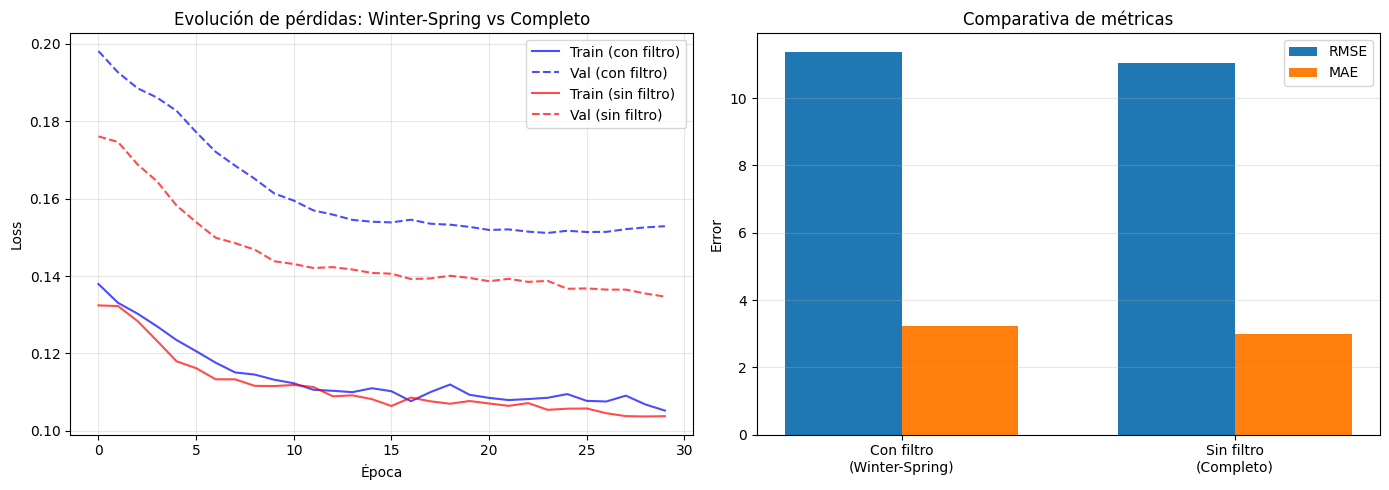

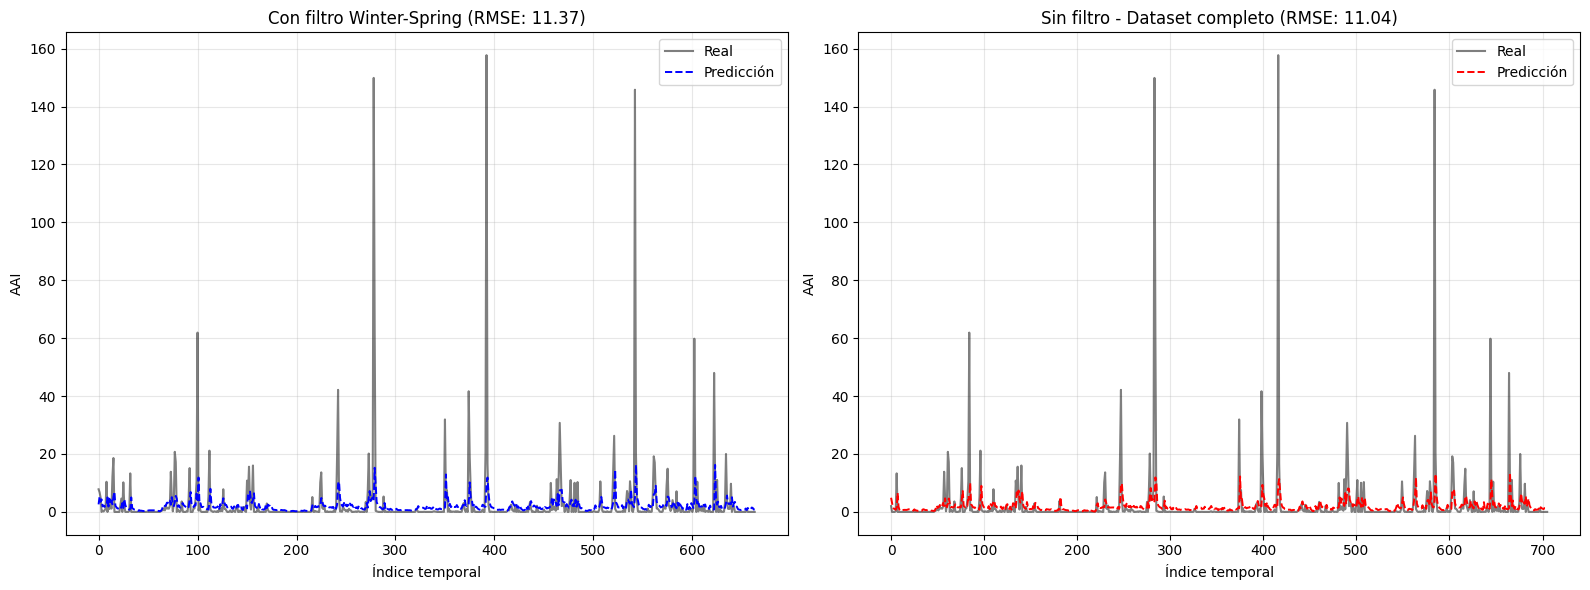

In [17]:
# ==========================================
# COMPARACIÓN: WINTER-SPRING vs DATASET COMPLETO (AvalancheLSTM h1=64, h2=32)
# ==========================================

EPOCHS_COMP = 30
LOOK_BACK_COMP = 7

# Preparar datos CON filtro winter-spring
def prepare_full_with_filter():
    df_obs = pd.read_csv('data_set_1_avalanche_observations_wi9899_to_wi1819_davos.csv', delimiter=';')
    df_daily = pd.read_csv('data_set_2_danger_avalanches.csv', delimiter=';')
    df_weather = pd.read_csv('davos_weather_1998_2019.csv', delimiter=';')

    df_obs['date_release'] = pd.to_datetime(df_obs['date_release'])
    df_daily['date'] = pd.to_datetime(df_daily['date'])
    df_weather['date'] = pd.to_datetime(df_weather['date'])

    df_obs_daily = df_obs.groupby('date_release').agg({
        'max_elevation_m': 'mean',
        'area_m2': 'sum'
    }).reset_index().rename(columns={'date_release': 'date'})

    df = pd.merge(df_daily[['date', 'AAI_all', 'max.danger.corr']], df_weather, on='date', how='inner')
    df = pd.merge(df, df_obs_daily, on='date', how='left')

    df['AAI_all'] = df['AAI_all'].fillna(0)
    df['area_m2'] = df['area_m2'].fillna(0)
    df['max_elevation_m'] = df['max_elevation_m'].fillna(0)
    df['max.danger.corr'] = df['max.danger.corr'].ffill().fillna(1)

    df['log_AAI'] = np.log1p(df['AAI_all'])
    df['snow_3d'] = df['snowfall'].rolling(window=3).sum().fillna(0)

    # CON filtro winter-spring
    df['month'] = df['date'].dt.month
    df = df[df['month'].isin([12, 1, 2, 3, 4, 5])].sort_values('date').reset_index(drop=True)

    features_comp = ['log_AAI', 'max.danger.corr', 'temp_mean', 'snowfall', 'wind_speed', 'max_elevation_m', 'area_m2', 'snow_3d']
    return df, features_comp

# Preparar datos SIN filtro (ya existe load_full_no_filter, la reutilizamos)
def prepare_full_no_filter_comp():
    df_full, feature_cols_comp = load_full_no_filter()
    data = df_full[feature_cols_comp].values
    scaler_comp = MinMaxScaler()
    data_scaled = scaler_comp.fit_transform(data)
    X, y = create_sequences(data_scaled, LOOK_BACK_COMP)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    return X_train, X_test, y_train, y_test, scaler_comp, feature_cols_comp

# Entrenar y evaluar modelo con filtro
print("=== Entrenando modelo CON filtro winter-spring ===")
df_filt, features_filt = prepare_full_with_filter()
data_filt = df_filt[features_filt].values
scaler_filt = MinMaxScaler()
data_scaled_filt = scaler_filt.fit_transform(data_filt)
X_filt, y_filt = create_sequences(data_scaled_filt, LOOK_BACK_COMP)
split_filt = int(len(X_filt) * 0.8)
X_train_filt, X_test_filt = X_filt[:split_filt], X_filt[split_filt:]
y_train_filt, y_test_filt = y_filt[:split_filt], y_filt[split_filt:]

train_loader_filt = DataLoader(AvalancheDataset(X_train_filt, y_train_filt), batch_size=32, shuffle=False)
val_loader_filt = DataLoader(AvalancheDataset(X_test_filt, y_test_filt), batch_size=32, shuffle=False)

model_filt = AvalancheLSTM(input_size=len(features_filt), hidden_layer_1=64, hidden_layer_2=32, output_size=1).to(device)
train_losses_filt, val_losses_filt = train_model(model_filt, train_loader_filt, val_loader_filt,
                                                  epochs=EPOCHS_COMP, model_type='lstm', patience=8)

model_filt.eval()
with torch.no_grad():
    test_preds_filt = model_filt(torch.FloatTensor(X_test_filt).to(device)).cpu().numpy()

dummy_filt = np.zeros((len(test_preds_filt), len(features_filt)))
dummy_filt[:, 0] = test_preds_filt.flatten()
inv_preds_filt = scaler_filt.inverse_transform(dummy_filt)[:, 0]
final_preds_filt = np.expm1(inv_preds_filt)

dummy_true_filt = np.zeros((len(y_test_filt), len(features_filt)))
dummy_true_filt[:, 0] = y_test_filt.flatten()
inv_true_filt = scaler_filt.inverse_transform(dummy_true_filt)[:, 0]
final_true_filt = np.expm1(inv_true_filt)

rmse_filt = np.sqrt(mean_squared_error(final_true_filt, final_preds_filt))
mae_filt = mean_absolute_error(final_true_filt, final_preds_filt)

print(f"RMSE (con filtro): {rmse_filt:.4f} | MAE: {mae_filt:.4f}")

# Entrenar y evaluar modelo sin filtro
print("\n=== Entrenando modelo SIN filtro (dataset completo) ===")
X_train_nf, X_test_nf, y_train_nf, y_test_nf, scaler_nf, features_nf = prepare_full_no_filter_comp()

train_loader_nf = DataLoader(AvalancheDataset(X_train_nf, y_train_nf), batch_size=32, shuffle=False)
val_loader_nf = DataLoader(AvalancheDataset(X_test_nf, y_test_nf), batch_size=32, shuffle=False)

model_nf = AvalancheLSTM(input_size=len(features_nf), hidden_layer_1=64, hidden_layer_2=32, output_size=1).to(device)
train_losses_nf, val_losses_nf = train_model(model_nf, train_loader_nf, val_loader_nf,
                                              epochs=EPOCHS_COMP, model_type='lstm', patience=8)

model_nf.eval()
with torch.no_grad():
    test_preds_nf = model_nf(torch.FloatTensor(X_test_nf).to(device)).cpu().numpy()

dummy_nf = np.zeros((len(test_preds_nf), len(features_nf)))
dummy_nf[:, 0] = test_preds_nf.flatten()
inv_preds_nf = scaler_nf.inverse_transform(dummy_nf)[:, 0]
final_preds_nf = np.expm1(inv_preds_nf)

dummy_true_nf = np.zeros((len(y_test_nf), len(features_nf)))
dummy_true_nf[:, 0] = y_test_nf.flatten()
inv_true_nf = scaler_nf.inverse_transform(dummy_true_nf)[:, 0]
final_true_nf = np.expm1(inv_true_nf)

rmse_nf = np.sqrt(mean_squared_error(final_true_nf, final_preds_nf))
mae_nf = mean_absolute_error(final_true_nf, final_preds_nf)

print(f"RMSE (sin filtro): {rmse_nf:.4f} | MAE: {mae_nf:.4f}")

# Gráfica comparativa de pérdidas
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_filt, label='Train (con filtro)', color='blue', alpha=0.7)
plt.plot(val_losses_filt, label='Val (con filtro)', color='blue', linestyle='--', alpha=0.7)
plt.plot(train_losses_nf, label='Train (sin filtro)', color='red', alpha=0.7)
plt.plot(val_losses_nf, label='Val (sin filtro)', color='red', linestyle='--', alpha=0.7)
plt.title('Evolución de pérdidas: Winter-Spring vs Completo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
labels = ['Con filtro\n(Winter-Spring)', 'Sin filtro\n(Completo)']
rmse_vals = [rmse_filt, rmse_nf]
mae_vals = [mae_filt, mae_nf]
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, rmse_vals, width, label='RMSE')
plt.bar(x + width/2, mae_vals, width, label='MAE')
plt.xticks(x, labels)
plt.ylabel('Error')
plt.title('Comparativa de métricas')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_winter_spring_vs_full.png', dpi=300, bbox_inches='tight')
plt.show()

# Gráfica comparativa de predicciones (muestras)
plt.figure(figsize=(16, 6))
idx_filt = np.arange(len(final_true_filt))
idx_nf = np.arange(len(final_true_nf))

plt.subplot(1, 2, 1)
plt.plot(idx_filt, final_true_filt, label='Real', color='black', alpha=0.5)
plt.plot(idx_filt, final_preds_filt, label='Predicción', color='blue', linestyle='--', linewidth=1.4)
plt.title(f'Con filtro Winter-Spring (RMSE: {rmse_filt:.2f})')
plt.xlabel('Índice temporal')
plt.ylabel('AAI')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(idx_nf, final_true_nf, label='Real', color='black', alpha=0.5)
plt.plot(idx_nf, final_preds_nf, label='Predicción', color='red', linestyle='--', linewidth=1.4)
plt.title(f'Sin filtro - Dataset completo (RMSE: {rmse_nf:.2f})')
plt.xlabel('Índice temporal')
plt.ylabel('AAI')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_predictions_winter_spring_vs_full.png', dpi=300, bbox_inches='tight')
plt.show()

# PARTE 1: DATASET INCOMPLETO

LSTM con dataset incompleto, solo con 4 columnas de datos -> menos eficiente que el último modelo


LSTM - DATASET INCOMPLETO (MODO WINTER_SPRING)
Iniciando entrenamiento LSTM...
Epoch 5/40 | Train Loss: 0.13641 | Val Loss: 0.14190
Epoch 10/40 | Train Loss: 0.12340 | Val Loss: 0.12859
Epoch 15/40 | Train Loss: 0.12072 | Val Loss: 0.12700
Epoch 20/40 | Train Loss: 0.11981 | Val Loss: 0.12752
Epoch 25/40 | Train Loss: 0.11883 | Val Loss: 0.12722
Epoch 30/40 | Train Loss: 0.11874 | Val Loss: 0.12880
Early stopping activado en epoch 32

Resultados Finales:
RMSE Real: 5.5667
MAE Real: 2.9986


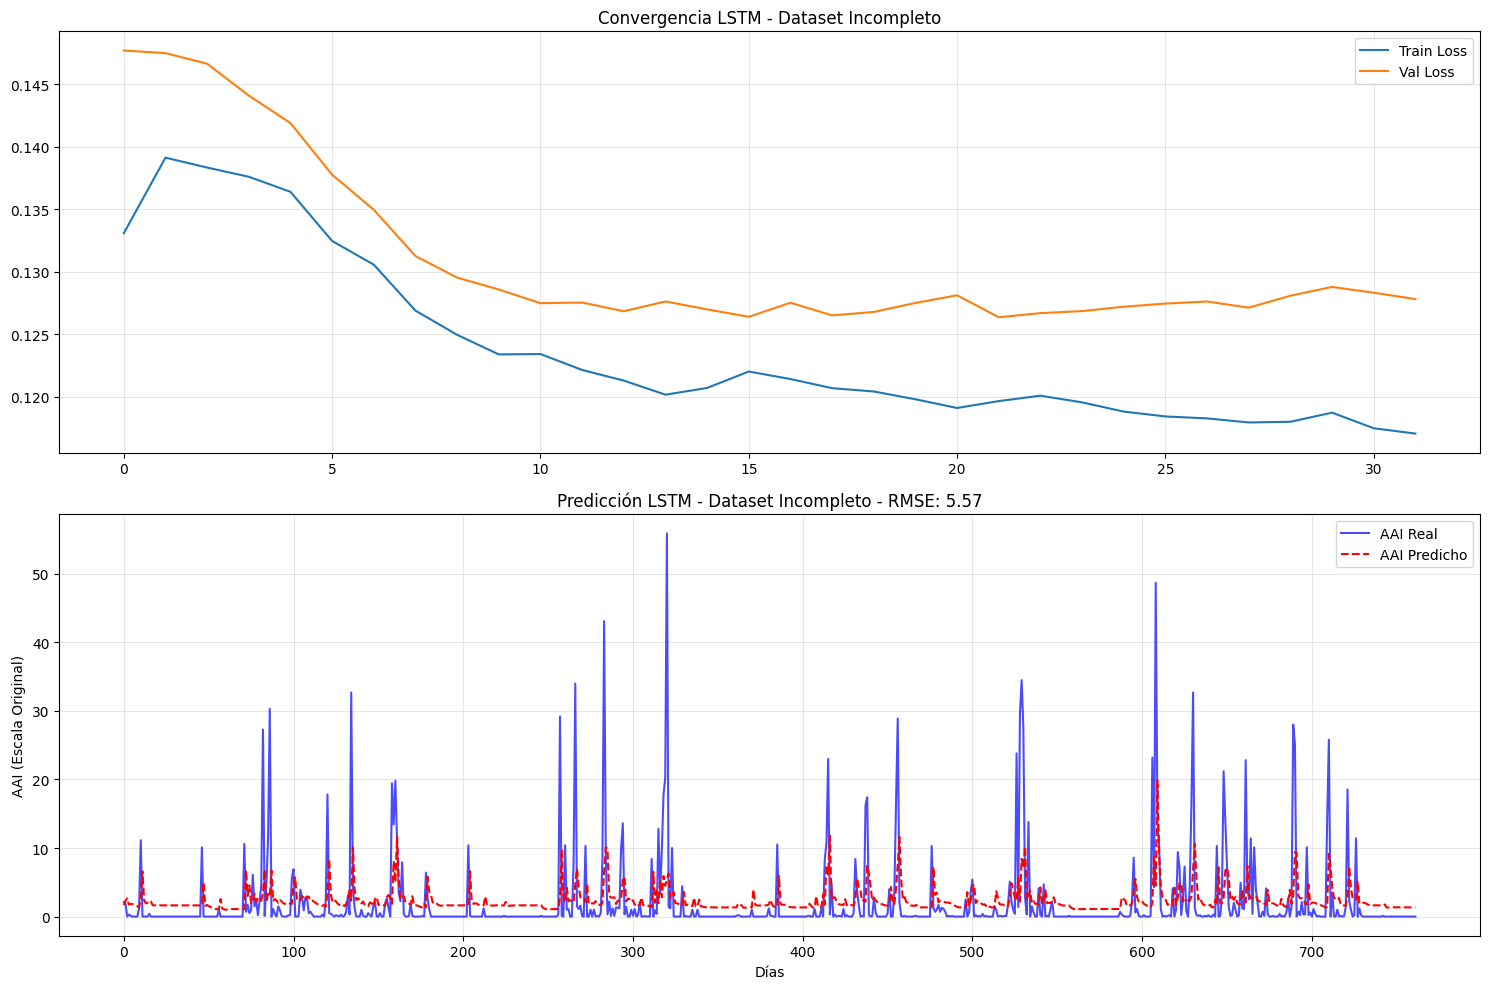

In [18]:
# Función para preparar datos del dataset incompleto
def prepare_incomplete_data(file_path, mode='winter_spring'):
    """Prepara datos del dataset incompleto (solo data_set_1)"""
    df = pd.read_csv(file_path, delimiter=';')
    df['date_release'] = pd.to_datetime(df['date_release'])
    df['month'] = df['date_release'].dt.month

    if mode == 'winter_spring':
        target_months = [12, 1, 2, 3, 4, 5]
        df_filtered = df[df['month'].isin(target_months)].copy()
    else:
        df_filtered = df.copy()

    # Rango completo
    all_dates = df_filtered['date_release'].unique()
    full_range = pd.date_range(start=min(all_dates), end=max(all_dates), freq='D')
    if mode == 'winter_spring':
        full_range = full_range[full_range.month.isin([12, 1, 2, 3, 4, 5])]

    daily_df = df_filtered.groupby('date_release').agg({
        'weight_AAI': 'sum',
        'max.danger.corr': 'max',
        'max_elevation_m': 'mean'
    }).rename(columns={
        'weight_AAI': 'total_aai',
        'max.danger.corr': 'danger_level',
        'max_elevation_m': 'mean_elev'
    })

    daily_df = daily_df.reindex(full_range)
    daily_df['total_aai'] = daily_df['total_aai'].fillna(0)
    daily_df['danger_level'] = daily_df['danger_level'].ffill().fillna(1.0)
    daily_df['mean_elev'] = daily_df['mean_elev'].fillna(2000.0)

    # Feature Engineering
    daily_df['log_aai'] = np.log1p(daily_df['total_aai'])
    daily_df['rolling_sum_3d'] = daily_df['log_aai'].rolling(window=3).sum().fillna(0)
    
    features = ['log_aai', 'danger_level', 'mean_elev', 'rolling_sum_3d']
    data_values = daily_df[features].values

    # Escalado
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_values)
    
    # Secuencias
    look_back = 10
    X, y = create_dataset_multi(scaled_data, look_back)
    
    # Split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler, features

# Ejecución LSTM con dataset incompleto
FILE_PATH_INCOMPLETE = 'data_set_1_avalanche_observations_wi9899_to_wi1819_davos.csv'
print(f"\n{'='*60}")
print("LSTM - DATASET INCOMPLETO (MODO WINTER_SPRING)")
print(f"{'='*60}")

# Preparar datos
X_train, X_test, y_train, y_test, scaler, features = prepare_incomplete_data(FILE_PATH_INCOMPLETE, mode='winter_spring')

# DataLoaders
train_dataset = AvalancheDataset(X_train, y_train)
test_dataset = AvalancheDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modelo
model = AvalancheLSTM(input_size=len(features)).to(device)

# Entrenar
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=40, model_type='lstm')

# Evaluación
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    test_pred_tensor = model(X_test_tensor)
    test_pred_np = test_pred_tensor.cpu().numpy()

# Inversión de escala
n_feat = len(features)
y_test_real = inverse_transform_target(y_test.reshape(-1,1), scaler, n_feat)
pred_test_real = inverse_transform_target(test_pred_np, scaler, n_feat)

rmse = np.sqrt(mean_squared_error(y_test_real, pred_test_real))
mae = mean_absolute_error(y_test_real, pred_test_real)

print(f"\nResultados Finales:")
print(f"RMSE Real: {rmse:.4f}")
print(f"MAE Real: {mae:.4f}")

# Gráficos
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Convergencia LSTM - Dataset Incompleto')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(y_test_real, label='AAI Real', color='blue', alpha=0.7)
plt.plot(pred_test_real, label='AAI Predicho', color='red', linestyle='--', linewidth=1.5)
plt.title(f'Predicción LSTM - Dataset Incompleto - RMSE: {rmse:.2f}')
plt.ylabel('AAI (Escala Original)')
plt.xlabel('Días')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('lstm_results_data_default_winter_spring.png')
plt.tight_layout()
plt.show()

# PARTE 2: DATASET COMPLETO

LSTM con el Dataset Completo, donde usamos 8 feautures -> mejor resultados que con 4 features


LSTM - DATASET COMPLETO
Iniciando entrenamiento LSTM...
Epoch 5/60 | Train Loss: 0.11286 | Val Loss: 0.16024
Epoch 10/60 | Train Loss: 0.10870 | Val Loss: 0.15421
Epoch 15/60 | Train Loss: 0.10767 | Val Loss: 0.15246
Epoch 20/60 | Train Loss: 0.10830 | Val Loss: 0.15334
Epoch 25/60 | Train Loss: 0.10585 | Val Loss: 0.15123
Epoch 30/60 | Train Loss: 0.10467 | Val Loss: 0.15242
Early stopping activado en epoch 33

Resultados Finales:
RMSE Real: 11.4818
MAE Real: 3.0738


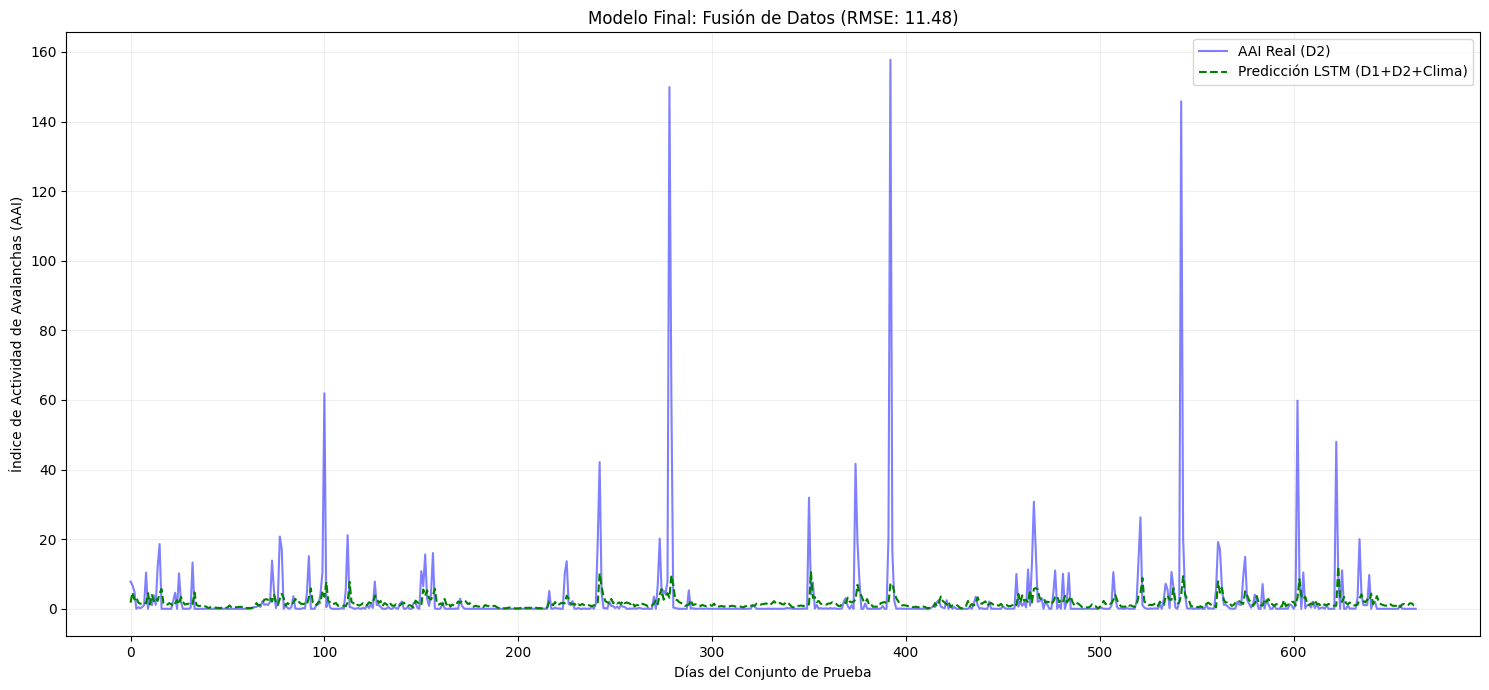

In [14]:
# Clase LSTM para dataset completo (puede tener arquitectura diferente)
class AvalancheLSTMFull(nn.Module):
    """LSTM optimizado para dataset completo con más features"""
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, output_dim=1):
        super(AvalancheLSTMFull, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Función para preparar datos del dataset completo
def prepare_full_data():
    """Prepara datos fusionando múltiples fuentes"""
    # Cargar los tres archivos
    df_obs = pd.read_csv('data_set_1_avalanche_observations_wi9899_to_wi1819_davos.csv', delimiter=';')
    df_daily = pd.read_csv('data_set_2_danger_avalanches.csv', delimiter=';')
    df_weather = pd.read_csv('davos_weather_1998_2019.csv', delimiter=';')

    # Estandarizar fechas
    df_obs['date_release'] = pd.to_datetime(df_obs['date_release'])
    df_daily['date'] = pd.to_datetime(df_daily['date'])
    df_weather['date'] = pd.to_datetime(df_weather['date'])

    # Agregar datos físicos (Dataset 1)
    df_obs_daily = df_obs.groupby('date_release').agg({
        'max_elevation_m': 'mean',
        'area_m2': 'sum'
    }).reset_index().rename(columns={'date_release': 'date'})

    # Fusión total
    df = pd.merge(df_daily[['date', 'AAI_all', 'max.danger.corr']], df_weather, on='date', how='inner')
    df = pd.merge(df, df_obs_daily, on='date', how='left')

    # Tratamiento de días sin actividad
    df['AAI_all'] = df['AAI_all'].fillna(0)
    df['area_m2'] = df['area_m2'].fillna(0)
    df['max_elevation_m'] = df['max_elevation_m'].fillna(0)
    df['max.danger.corr'] = df['max.danger.corr'].ffill().fillna(1)
    
    # Ingeniería de características
    df['log_AAI'] = np.log1p(df['AAI_all'])
    df['snow_3d'] = df['snowfall'].rolling(window=3).sum().fillna(0)
    
    # Filtro estacional (Invierno y Primavera)
    df['month'] = df['date'].dt.month
    df = df[df['month'].isin([12, 1, 2, 3, 4, 5])].sort_values('date').reset_index(drop=True)

    # Definición de variables de entrada
    features = ['log_AAI', 'max.danger.corr', 'temp_mean', 'snowfall', 'wind_speed', 'max_elevation_m', 'area_m2', 'snow_3d']
    return df, features

# Ejecución LSTM con dataset completo
print(f"\n{'='*60}")
print("LSTM - DATASET COMPLETO")
print(f"{'='*60}")

# Preparar datos
df_full, feature_cols = prepare_full_data()
data = df_full[feature_cols].values

# Escalado
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Crear Secuencias (7 días de historial)
X, y = create_sequences(data_scaled, 7)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# DataLoader
train_loader = DataLoader(AvalancheDataset(X_train, y_train), batch_size=32, shuffle=False)
val_loader = DataLoader(AvalancheDataset(X_test, y_test), batch_size=32, shuffle=False)

# Inicializar modelo
model = AvalancheLSTMFull(input_dim=len(feature_cols)).to(device)

# Entrenar
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=60, model_type='lstm')

# Evaluación
model.eval()
with torch.no_grad():
    test_preds = model(torch.FloatTensor(X_test).to(device)).cpu().numpy()

# Inversión de transformaciones
dummy = np.zeros((len(test_preds), len(feature_cols)))
dummy[:, 0] = test_preds.flatten()
inv_preds = scaler.inverse_transform(dummy)[:, 0]
final_preds = np.expm1(inv_preds)

dummy_true = np.zeros((len(y_test), len(feature_cols)))
dummy_true[:, 0] = y_test.flatten()
inv_true = scaler.inverse_transform(dummy_true)[:, 0]
final_true = np.expm1(inv_true)

rmse = np.sqrt(mean_squared_error(final_true, final_preds))
mae = mean_absolute_error(final_true, final_preds)

print(f"\nResultados Finales:")
print(f"RMSE Real: {rmse:.4f}")
print(f"MAE Real: {mae:.4f}")

# Visualización
plt.figure(figsize=(15, 7))
plt.plot(final_true, label='AAI Real (D2)', color='blue', alpha=0.5)
plt.plot(final_preds, label='Predicción LSTM (D1+D2+Clima)', color='green', linestyle='--')
plt.title(f'Modelo Final: Fusión de Datos (RMSE: {rmse:.2f})')
plt.ylabel('Índice de Actividad de Avalanchas (AAI)')
plt.xlabel('Días del Conjunto de Prueba')
plt.legend()
plt.grid(True, alpha=0.2)
plt.savefig('lstm_fusion_results.png')
plt.tight_layout()
plt.show()


# COMPARACIONES DATASETS INCOMPLETO VS COMPLETO

Gráficas comparativas de ambos modelos con diferentes conjunto de datos de entrenamiento

=== Evaluando Dataset Incompleto ===
Iniciando entrenamiento LSTM...
Epoch 5/30 | Train Loss: 0.13681 | Val Loss: 0.14157
Epoch 10/30 | Train Loss: 0.12689 | Val Loss: 0.13006
Epoch 15/30 | Train Loss: 0.12391 | Val Loss: 0.12655
Epoch 20/30 | Train Loss: 0.12302 | Val Loss: 0.12609
Epoch 25/30 | Train Loss: 0.12270 | Val Loss: 0.12591
Early stopping activado en epoch 27
RMSE (incompleto): 5.5007 | MAE: 3.0228
Features usadas: ['log_aai', 'danger_level', 'mean_elev', 'rolling_sum_3d']

=== Evaluando modelo 2.1 (Dataset Completo) ===
Iniciando entrenamiento LSTM...
Epoch 5/30 | Train Loss: 0.11223 | Val Loss: 0.16266
Epoch 10/30 | Train Loss: 0.10882 | Val Loss: 0.15443
Epoch 15/30 | Train Loss: 0.10897 | Val Loss: 0.15257
Epoch 20/30 | Train Loss: 0.10528 | Val Loss: 0.15194
Epoch 25/30 | Train Loss: 0.10661 | Val Loss: 0.15187
Epoch 30/30 | Train Loss: 0.10604 | Val Loss: 0.15191
RMSE (completo): 11.4308 | MAE: 3.1186
Features usadas: ['log_AAI', 'max.danger.corr', 'temp_mean', 'snowf

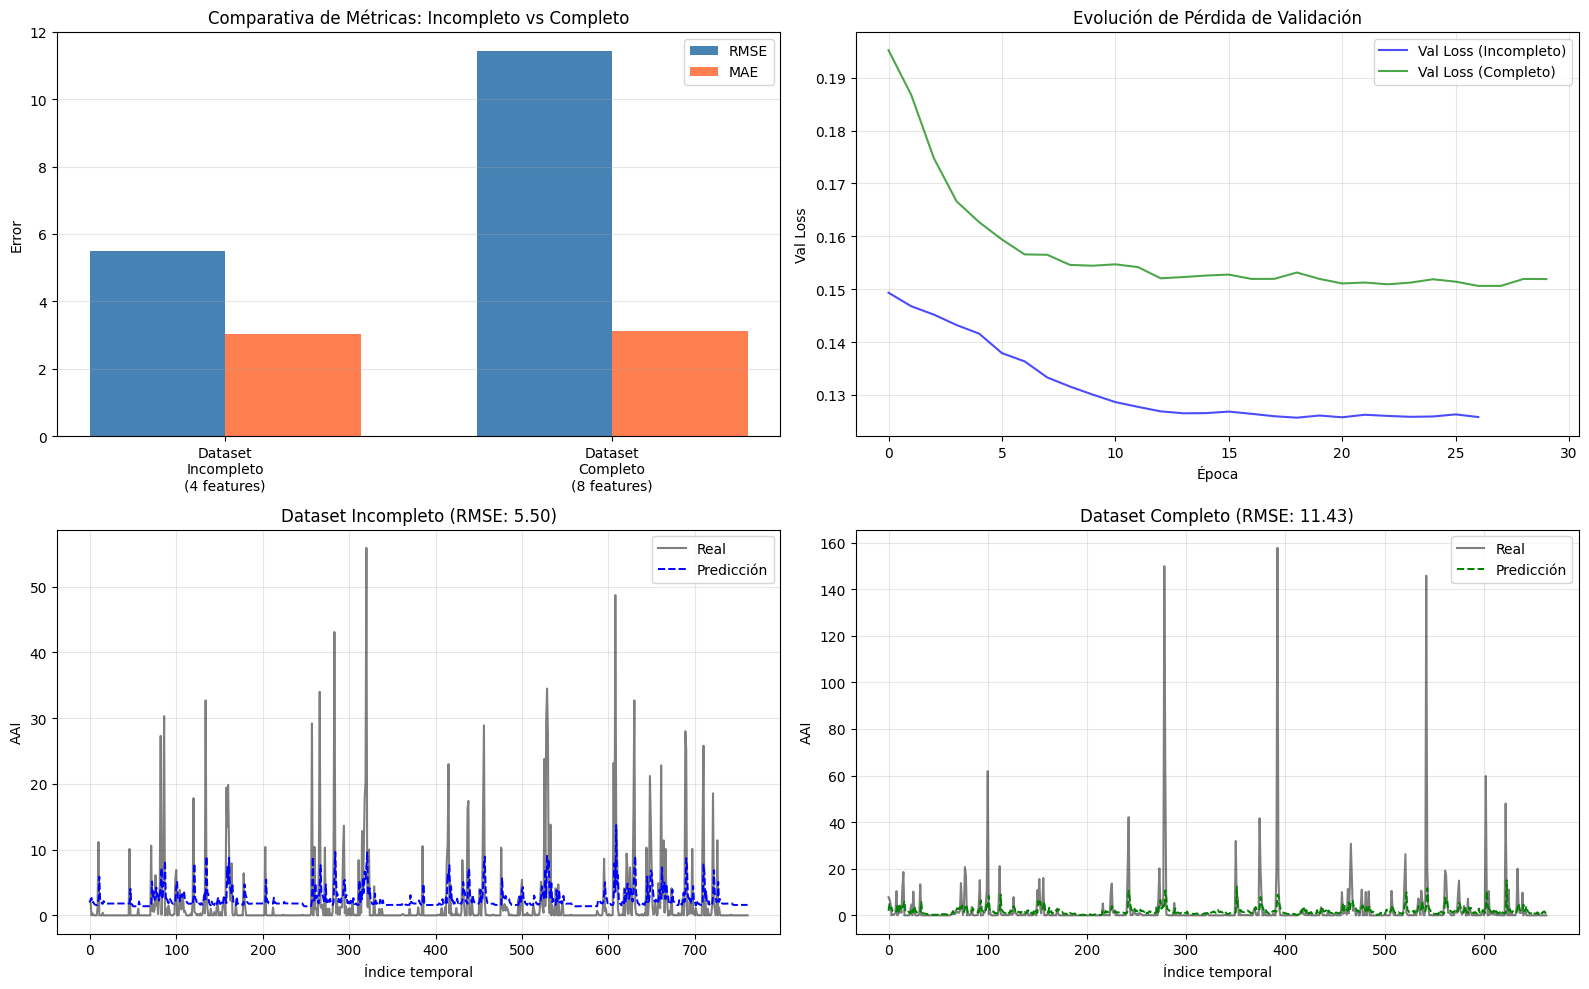

In [19]:
# ==========================================
# COMPARACIÓN: DATASET INCOMPLETO vs COMPLETO
# ==========================================
print("=== Evaluando Dataset Incompleto ===")
FILE_PATH_INCOMPLETE = 'data_set_1_avalanche_observations_wi9899_to_wi1819_davos.csv'
X_train_inc, X_test_inc, y_train_inc, y_test_inc, scaler_inc, features_inc = prepare_incomplete_data(
    FILE_PATH_INCOMPLETE, mode='winter_spring'
)

model_inc = AvalancheLSTM(input_size=len(features_inc)).to(device)
train_dataset_inc = AvalancheDataset(X_train_inc, y_train_inc)
test_dataset_inc = AvalancheDataset(X_test_inc, y_test_inc)
train_loader_inc = DataLoader(train_dataset_inc, batch_size=32, shuffle=False)
val_loader_inc = DataLoader(test_dataset_inc, batch_size=32, shuffle=False)

# Entrenar modelo incompleto (corto para comparación justa)
train_losses_inc, val_losses_inc = train_model(model_inc, train_loader_inc, val_loader_inc, 
                                                epochs=30, model_type='lstm', patience=8)

model_inc.eval()
with torch.no_grad():
    test_preds_inc = model_inc(torch.FloatTensor(X_test_inc).to(device)).cpu().numpy()

n_feat_inc = len(features_inc)
y_test_real_inc = inverse_transform_target(y_test_inc.reshape(-1,1), scaler_inc, n_feat_inc)
pred_test_real_inc = inverse_transform_target(test_preds_inc, scaler_inc, n_feat_inc)

rmse_inc = np.sqrt(mean_squared_error(y_test_real_inc, pred_test_real_inc))
mae_inc = mean_absolute_error(y_test_real_inc, pred_test_real_inc)

print(f"RMSE (incompleto): {rmse_inc:.4f} | MAE: {mae_inc:.4f}")
print(f"Features usadas: {features_inc}")

# Reconstruir métricas del modelo 2.1 (dataset completo)
print("\n=== Evaluando modelo 2.1 (Dataset Completo) ===")
df_full_comp, feature_cols_comp = prepare_full_data()
data_comp = df_full_comp[feature_cols_comp].values
scaler_comp = MinMaxScaler()
data_scaled_comp = scaler_comp.fit_transform(data_comp)

X_comp, y_comp = create_sequences(data_scaled_comp, 7)
split_comp = int(len(X_comp) * 0.8)
X_train_comp, X_test_comp = X_comp[:split_comp], X_comp[split_comp:]
y_train_comp, y_test_comp = y_comp[:split_comp], y_comp[split_comp:]

train_loader_comp = DataLoader(AvalancheDataset(X_train_comp, y_train_comp), batch_size=32, shuffle=False)
val_loader_comp = DataLoader(AvalancheDataset(X_test_comp, y_test_comp), batch_size=32, shuffle=False)

model_comp = AvalancheLSTMFull(input_dim=len(feature_cols_comp)).to(device)
train_losses_comp, val_losses_comp = train_model(model_comp, train_loader_comp, val_loader_comp,
                                                  epochs=30, model_type='lstm', patience=8)

model_comp.eval()
with torch.no_grad():
    test_preds_comp = model_comp(torch.FloatTensor(X_test_comp).to(device)).cpu().numpy()

dummy_comp = np.zeros((len(test_preds_comp), len(feature_cols_comp)))
dummy_comp[:, 0] = test_preds_comp.flatten()
inv_preds_comp = scaler_comp.inverse_transform(dummy_comp)[:, 0]
final_preds_comp = np.expm1(inv_preds_comp)

dummy_true_comp = np.zeros((len(y_test_comp), len(feature_cols_comp)))
dummy_true_comp[:, 0] = y_test_comp.flatten()
inv_true_comp = scaler_comp.inverse_transform(dummy_true_comp)[:, 0]
final_true_comp = np.expm1(inv_true_comp)

rmse_comp = np.sqrt(mean_squared_error(final_true_comp, final_preds_comp))
mae_comp = mean_absolute_error(final_true_comp, final_preds_comp)

print(f"RMSE (completo): {rmse_comp:.4f} | MAE: {mae_comp:.4f}")
print(f"Features usadas: {feature_cols_comp}")

# Gráficas comparativas
plt.figure(figsize=(16, 10))

# 1) Comparativa de métricas
plt.subplot(2, 2, 1)
labels = ['Dataset\nIncompleto\n(4 features)', 'Dataset\nCompleto\n(8 features)']
rmse_vals = [rmse_inc, rmse_comp]
mae_vals = [mae_inc, mae_comp]
x = np.arange(len(labels))
width = 0.35
plt.bar(x - width/2, rmse_vals, width, label='RMSE', color='steelblue')
plt.bar(x + width/2, mae_vals, width, label='MAE', color='coral')
plt.xticks(x, labels)
plt.ylabel('Error')
plt.title('Comparativa de Métricas: Incompleto vs Completo')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)

# 2) Evolución de pérdidas de validación
plt.subplot(2, 2, 2)
plt.plot(val_losses_inc, label='Val Loss (Incompleto)', color='blue', alpha=0.7)
plt.plot(val_losses_comp, label='Val Loss (Completo)', color='green', alpha=0.7)
plt.title('Evolución de Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Val Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 3) Predicciones - Dataset Incompleto
plt.subplot(2, 2, 3)
idx_inc = np.arange(len(y_test_real_inc))
plt.plot(idx_inc, y_test_real_inc, label='Real', color='black', alpha=0.5)
plt.plot(idx_inc, pred_test_real_inc, label='Predicción', color='blue', linestyle='--', linewidth=1.4)
plt.title(f'Dataset Incompleto (RMSE: {rmse_inc:.2f})')
plt.xlabel('Índice temporal')
plt.ylabel('AAI')
plt.legend()
plt.grid(True, alpha=0.3)

# 4) Predicciones - Dataset Completo
plt.subplot(2, 2, 4)
idx_comp = np.arange(len(final_true_comp))
plt.plot(idx_comp, final_true_comp, label='Real', color='black', alpha=0.5)
plt.plot(idx_comp, final_preds_comp, label='Predicción', color='green', linestyle='--', linewidth=1.4)
plt.title(f'Dataset Completo (RMSE: {rmse_comp:.2f})')
plt.xlabel('Índice temporal')
plt.ylabel('AAI')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_incomplete_vs_complete.png', dpi=300, bbox_inches='tight')
plt.show()

# PARTE 3: TRATAMIENTO DE OUTLIERS

## ¿Qué son los Outliers?

Los **outliers** (valores atípicos) son observaciones que se desvían significativamente del resto de los datos. En el contexto de predicción de avalanchas, estos valores pueden ser:

- **Valores extremadamente altos**: Días con actividad de avalanchas anormalmente elevada
- **Valores extremadamente bajos**: Días con valores inesperadamente bajos
- **Errores de medición**: Datos incorrectos o mal registrados

## ¿Por qué tratarlos?

Los outliers pueden afectar negativamente el entrenamiento de modelos de machine learning porque:

1. **Sesgan el modelo**: El modelo intenta ajustarse a estos valores extremos, perjudicando su capacidad de generalización
2. **Afectan las métricas**: Pueden inflar artificialmente el error (RMSE, MAE)
3. **Reducen la calidad de las predicciones**: El modelo puede aprender patrones erróneos

## Método de Detección y Limpieza

En esta sección utilizaremos el método **IQR (Interquartile Range)** para detectar outliers:

- **Rango Intercuartílico (IQR)**: Diferencia entre el percentil 75 (Q3) y el percentil 25 (Q1)
- **Límites**: 
  - Límite inferior = Q1 - 1.5 × IQR
  - Límite superior = Q3 + 1.5 × IQR
- **Valores fuera de estos límites se consideran outliers**

Los outliers detectados serán **reemplazados** usando interpolación o valores límite, manteniendo la continuidad temporal de la serie.

In [23]:
# ==========================================
# FUNCIONES PARA DETECCIÓN Y LIMPIEZA DE OUTLIERS
# ==========================================

def detect_outliers_iqr(data, column_name=None):
    """Detecta outliers usando el método IQR (Interquartile Range)"""
    if column_name is not None:
        values = data[column_name].values
    else:
        values = data if isinstance(data, np.ndarray) else np.array(data)
    
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    mask = (values < lower_bound) | (values > upper_bound)
    
    return mask, lower_bound, upper_bound

def clean_outliers_interpolation(data, column_name=None):
    """Limpia outliers reemplazándolos por interpolación"""
    if isinstance(data, pd.DataFrame) and column_name is not None:
        data_cleaned = data.copy()
        values = data[column_name].values
    else:
        data_cleaned = data.copy() if isinstance(data, np.ndarray) else np.array(data).copy()
        values = data_cleaned
        column_name = None
    
    # Detectar outliers
    mask, lower_bound, upper_bound = detect_outliers_iqr(values)
    n_outliers = np.sum(mask)
    
    if n_outliers > 0:
        # Crear índices para interpolación
        indices = np.arange(len(values))
        
        # Reemplazar outliers con NaN para poder interpolar
        values_clean = values.copy()
        values_clean[mask] = np.nan
        
        # Interpolar valores faltantes
        if isinstance(data, pd.DataFrame):
            data_cleaned[column_name] = pd.Series(values_clean).interpolate(method='linear', limit_direction='both').values
        else:
            valid_indices = ~np.isnan(values_clean)
            if np.sum(valid_indices) > 1:
                data_cleaned = np.interp(indices, indices[valid_indices], values_clean[valid_indices])
            else:
                #usamos la mediana si no esta la cosa bien compi
                data_cleaned = np.where(mask, np.nanmedian(values), values_clean)
                data_cleaned = np.nan_to_num(data_cleaned, nan=np.nanmedian(values))
    
    return data_cleaned, n_outliers

# ==========================================
# LSTM CON DATOS LIMPIADOS DE OUTLIERS
# ==========================================

def prepare_incomplete_data_with_outlier_cleaning(file_path, mode='winter_spring'):
    """Prepara datos del dataset incompleto limpiando outliers antes de crear secuencias."""
    df = pd.read_csv(file_path, delimiter=';')
    df['date_release'] = pd.to_datetime(df['date_release'])
    df['month'] = df['date_release'].dt.month

    if mode == 'winter_spring':
        target_months = [12, 1, 2, 3, 4, 5]
        df_filtered = df[df['month'].isin(target_months)].copy()
    else:
        df_filtered = df.copy()

    # Rango completo
    all_dates = df_filtered['date_release'].unique()
    full_range = pd.date_range(start=min(all_dates), end=max(all_dates), freq='D')
    if mode == 'winter_spring':
        full_range = full_range[full_range.month.isin([12, 1, 2, 3, 4, 5])]

    daily_df = df_filtered.groupby('date_release').agg({
        'weight_AAI': 'sum',
        'max.danger.corr': 'max',
        'max_elevation_m': 'mean'
    }).rename(columns={
        'weight_AAI': 'total_aai',
        'max.danger.corr': 'danger_level',
        'max_elevation_m': 'mean_elev'
    })

    daily_df = daily_df.reindex(full_range)
    daily_df['total_aai'] = daily_df['total_aai'].fillna(0)
    daily_df['danger_level'] = daily_df['danger_level'].ffill().fillna(1.0)
    daily_df['mean_elev'] = daily_df['mean_elev'].fillna(2000.0)

    # Transformacion logaritmica
    daily_df['log_aai'] = np.log1p(daily_df['total_aai'])
    daily_df['rolling_sum_3d'] = daily_df['log_aai'].rolling(window=3).sum().fillna(0)
    
    # ==========================================
    # LIMPIEZA DE OUTLIERS
    # ==========================================
    
    # Limpiar outliers en cada columna relevante
    columns_to_clean = ['log_aai', 'danger_level', 'mean_elev', 'rolling_sum_3d']
    total_outliers = 0
    
    for col in columns_to_clean:
        print(f"\nProcesando columna: {col}")
        mask, lower_bound, upper_bound = detect_outliers_iqr(daily_df, col)
        n_outliers = np.sum(mask)
        total_outliers += n_outliers
        
        if n_outliers > 0:
            print(f"  - Outliers detectados: {n_outliers} ({100*n_outliers/len(daily_df):.2f}%)")
            print(f"  - Límites: [{lower_bound:.2f}, {upper_bound:.2f}]")
            # Limpiar outliers usando interpolación
            daily_df_cleaned, _ = clean_outliers_interpolation(daily_df, col)
            daily_df[col] = daily_df_cleaned[col]
        else:
            print(f"  - No se detectaron outliers")
    
    print(f"\n{'='*60}")
    print(f"Total de outliers limpiados: {total_outliers}")
    print(f"{'='*60}\n")
    
    # Continuar con el procesamiento normal
    features = ['log_aai', 'danger_level', 'mean_elev', 'rolling_sum_3d']
    data_values = daily_df[features].values

    # Escalado
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_values)
    
    # Secuencias
    look_back = 10
    X, y = create_dataset_multi(scaled_data, look_back)
    
    # Split
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, X_test, y_train, y_test, scaler, features, daily_df

## 3.1 LSTM - Dataset con Outliers Limpiados

En esta sección implementaremos un modelo LSTM utilizando los datos del dataset incompleto pero con outliers limpiados. Esto nos permitirá comparar el rendimiento del modelo con y sin tratamiento de outliers.

**Características de esta implementación:**
- Detección y limpieza de outliers usando método IQR
- Reemplazo de outliers mediante interpolación lineal
- Modelo LSTM con la misma arquitectura que en la Parte 1
- Predicciones mostradas para **todo el conjunto de datos** (train + test) para visualizar el comportamiento completo del modelo



Procesando columna: log_aai
  - Outliers detectados: 613 (16.06%)
  - Límites: [-0.55, 0.73]

Procesando columna: danger_level
  - No se detectaron outliers

Procesando columna: mean_elev
  - No se detectaron outliers

Procesando columna: rolling_sum_3d
  - Outliers detectados: 150 (3.93%)
  - Límites: [-4.06, 5.42]

Total de outliers limpiados: 763


Modelo creado:
  - Input size: 4
  - Device: cpu
Iniciando entrenamiento LSTM...
Epoch 5/100 | Train Loss: 0.26835 | Val Loss: 0.33694
Epoch 10/100 | Train Loss: 0.25324 | Val Loss: 0.30794
Epoch 15/100 | Train Loss: 0.27029 | Val Loss: 0.29805
Epoch 20/100 | Train Loss: 0.24695 | Val Loss: 0.29332
Epoch 25/100 | Train Loss: 0.24874 | Val Loss: 0.29240
Epoch 30/100 | Train Loss: 0.24434 | Val Loss: 0.28134
Epoch 35/100 | Train Loss: 0.24233 | Val Loss: 0.27154
Epoch 40/100 | Train Loss: 0.23613 | Val Loss: 0.26947
Epoch 45/100 | Train Loss: 0.23223 | Val Loss: 0.26678
Epoch 50/100 | Train Loss: 0.23416 | Val Loss: 0.26131
Epoch 55/100 | 

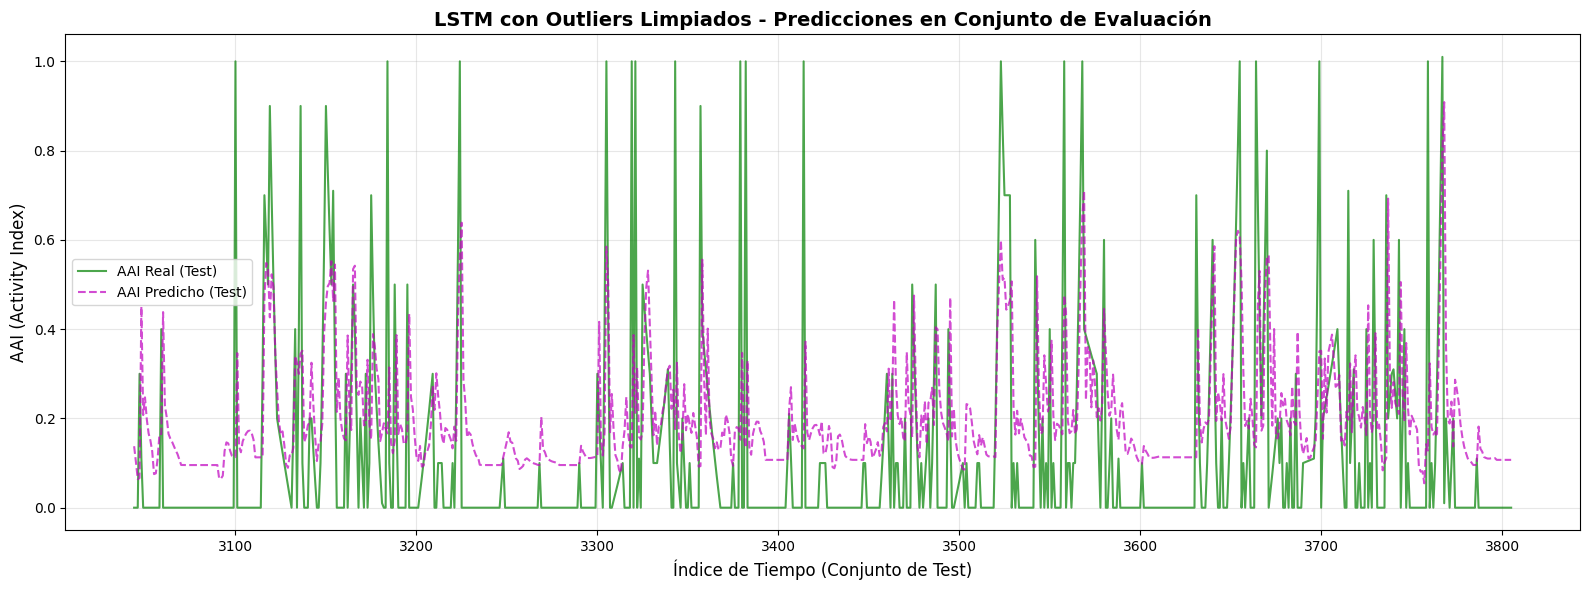

In [25]:
FILE_PATH_INCOMPLETE = 'data_set_1_avalanche_observations_wi9899_to_wi1819_davos.csv'

# Preparar datos con limpieza de outliers
X_train, X_test, y_train, y_test, scaler, features, daily_df = prepare_incomplete_data_with_outlier_cleaning(
    FILE_PATH_INCOMPLETE, mode='winter_spring'
)

# ==========================================
# CREACIÓN DE DATALOADERS
# ==========================================
train_dataset = AvalancheDataset(X_train, y_train)
test_dataset = AvalancheDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ==========================================
# CREACIÓN Y ENTRENAMIENTO DEL MODELO
# ==========================================
input_size = len(features)
model = AvalancheLSTM(input_size=input_size, hidden_layer_1=64, hidden_layer_2=32, output_size=1)
model = model.to(device)

print(f"\nModelo creado:")
print(f"  - Input size: {input_size}")
print(f"  - Device: {device}")

train_losses, val_losses = train_model(
    model, train_loader, test_loader, 
    epochs=100, lr=0.001, model_type='lstm', patience=10
)

# ==========================================
# EVALUACIÓN Y PREDICCIONES
# ==========================================
model.eval()
all_predictions = []
all_actuals = []

# Predicciones en conjunto de entrenamiento
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch)
        all_predictions.append(pred.cpu().numpy())
        all_actuals.append(y_batch.numpy())

# Predicciones en conjunto de prueba
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch)
        all_predictions.append(pred.cpu().numpy())
        all_actuals.append(y_batch.numpy())

# Concatenar todas las predicciones
all_predictions = np.concatenate(all_predictions, axis=0)
all_actuals = np.concatenate(all_actuals, axis=0)

# Transformar inversa
predictions_original = inverse_transform_target(all_predictions, scaler, len(features))
actuals_original = inverse_transform_target(all_actuals, scaler, len(features))

# ==========================================
# MÉTRICAS
# ==========================================
mse = mean_squared_error(actuals_original, predictions_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals_original, predictions_original)
r2 = r2_score(actuals_original, predictions_original)

print(f"\n{'='*60}")
print("MÉTRICAS DEL MODELO (TODO EL DATASET)")
print(f"{'='*60}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"{'='*60}")

# ==========================================
# VISUALIZACIÓN - SOLO DATOS DE EVALUACIÓN (TEST)
# ==========================================

# Índices de tiempo
time_indices = np.arange(len(predictions_original))

# Tamaño de train (ya lo tienes de antes)
train_size = len(X_train)
test_indices = time_indices[train_size:]

# Extraer solo la parte de test
y_test_eval = actuals_original[train_size:]
y_pred_eval = predictions_original[train_size:]

plt.figure(figsize=(16, 6))
plt.plot(test_indices, y_test_eval, 'g-', label='AAI Real (Test)', alpha=0.7, linewidth=1.5)
plt.plot(test_indices, y_pred_eval, 'm--', label='AAI Predicho (Test)', alpha=0.7, linewidth=1.5)
plt.xlabel('Índice de Tiempo (Conjunto de Test)', fontsize=12)
plt.ylabel('AAI (Activity Index)', fontsize=12)
plt.title('LSTM con Outliers Limpiados - Predicciones en Conjunto de Evaluación', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_outliers_cleaned_results.png', dpi=300, bbox_inches='tight')
print("\nGráfico guardado como: lstm_outliers_cleaned_results.png")
plt.show()

## 3.2 Umbral sobre las predicciones (AAI < 0.12 → 0)

En esta sección aplicamos un **umbral de 0.12** sobre las predicciones del modelo:

- Si el modelo predice un valor de AAI **por debajo de 0.12**, lo transformamos a **0**.
- Los valores reales (`y_test_real`) se mantienen sin cambios (escala normal).
- Mostramos una nueva gráfica comparando las predicciones umbralizadas con los valores reales.


Umbral aplicado: 2
Nº de predicciones <= umbral (puestas a 0): 468 de 762

RESULTADOS CON UMBRAL (AAI < 0.12 → 0)
RMSE (test): 5.5365
MAE  (test): 2.2973


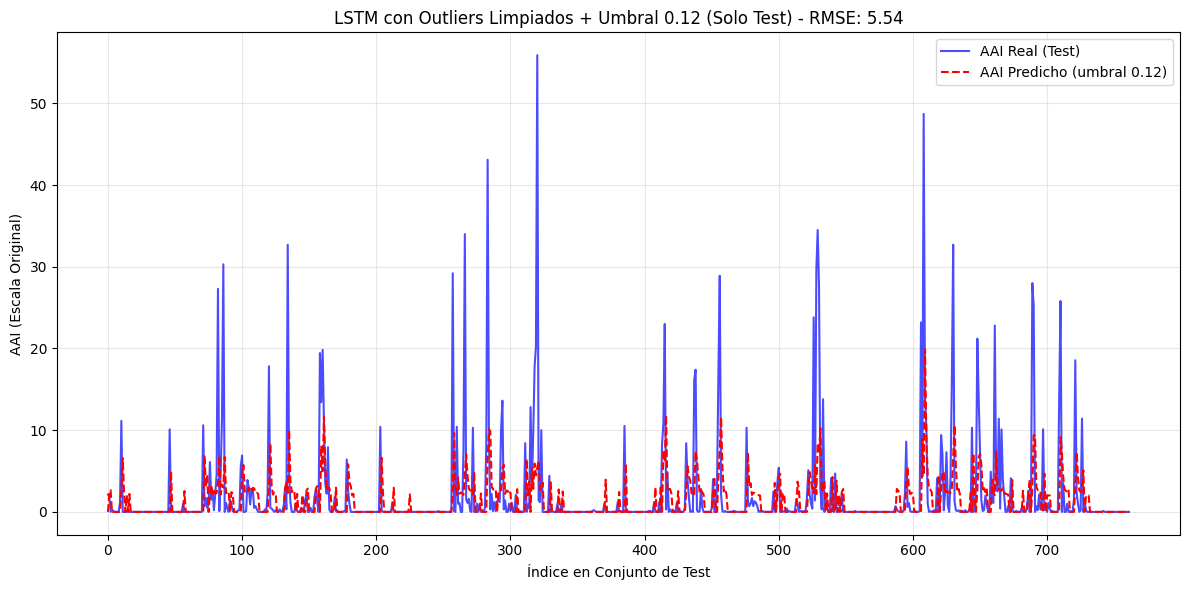

In [ ]:
# ==========================================
# APLICAR UMBRAL 0.12 A LAS PREDICCIONES Y GRAFICAR (SOLO TEST)
# ==========================================

THRESHOLD = 2 

# y_test_real y pred_test_real vienen de la celda 3.1 (solo conjunto de test)
# Creamos una copia para no modificar el original
pred_test_thresholded = pred_test_real.copy()

# Máscara de puntos por debajo del umbral
below_mask = pred_test_thresholded < THRESHOLD
n_below = below_mask.sum()

# Aplicar umbral: todo lo que sea menor que 0.12 pasa a 0
pred_test_thresholded[below_mask] = 0.0

print(f"Nº de predicciones <= umbral (puestas a 0): {n_below} de {len(pred_test_real)}")

# Métricas después de aplicar el umbral (solo test)
rmse_thr = np.sqrt(mean_squared_error(y_test_real, pred_test_thresholded))
mae_thr = mean_absolute_error(y_test_real, pred_test_thresholded)

print(f"RMSE (test): {rmse_thr:.4f}")
print(f"MAE  (test): {mae_thr:.4f}")

# Gráfica comparando reales vs predicciones umbralizadas (solo test)
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='AAI Real (Test)', color='blue', alpha=0.7)
plt.plot(pred_test_thresholded, label='AAI Predicho (umbral 0.12)', color='red', linestyle='--', linewidth=1.5)
plt.title(f'LSTM con Outliers Limpiados + Umbral 0.12 (Solo Test) - RMSE: {rmse_thr:.2f}')
plt.ylabel('AAI (Escala Original)')
plt.xlabel('Índice en Conjunto de Test')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_outliers_cleaned_threshold_012.png', dpi=300, bbox_inches='tight')
plt.show()

# PARTE 4: COMPARATIVAS MODELOS FINALES

Se usan las variables del último modelo entrenado en la parte de outliers (4 features):
- Grafica 1: Escala logarítmica con umbral 0.12 sobre todo el dataset (train+test).
- Grafica 2: Escala normal (sin umbral) sobre todo el dataset (train+test).
- Diagrama de barras comparando RMSE/MAE entre estos dos modos.

RMSE log (umbral 0.12): 0.1574 | MAE log: 0.1093
RMSE normal (sin umbral): 0.2060 | MAE normal: 0.1573


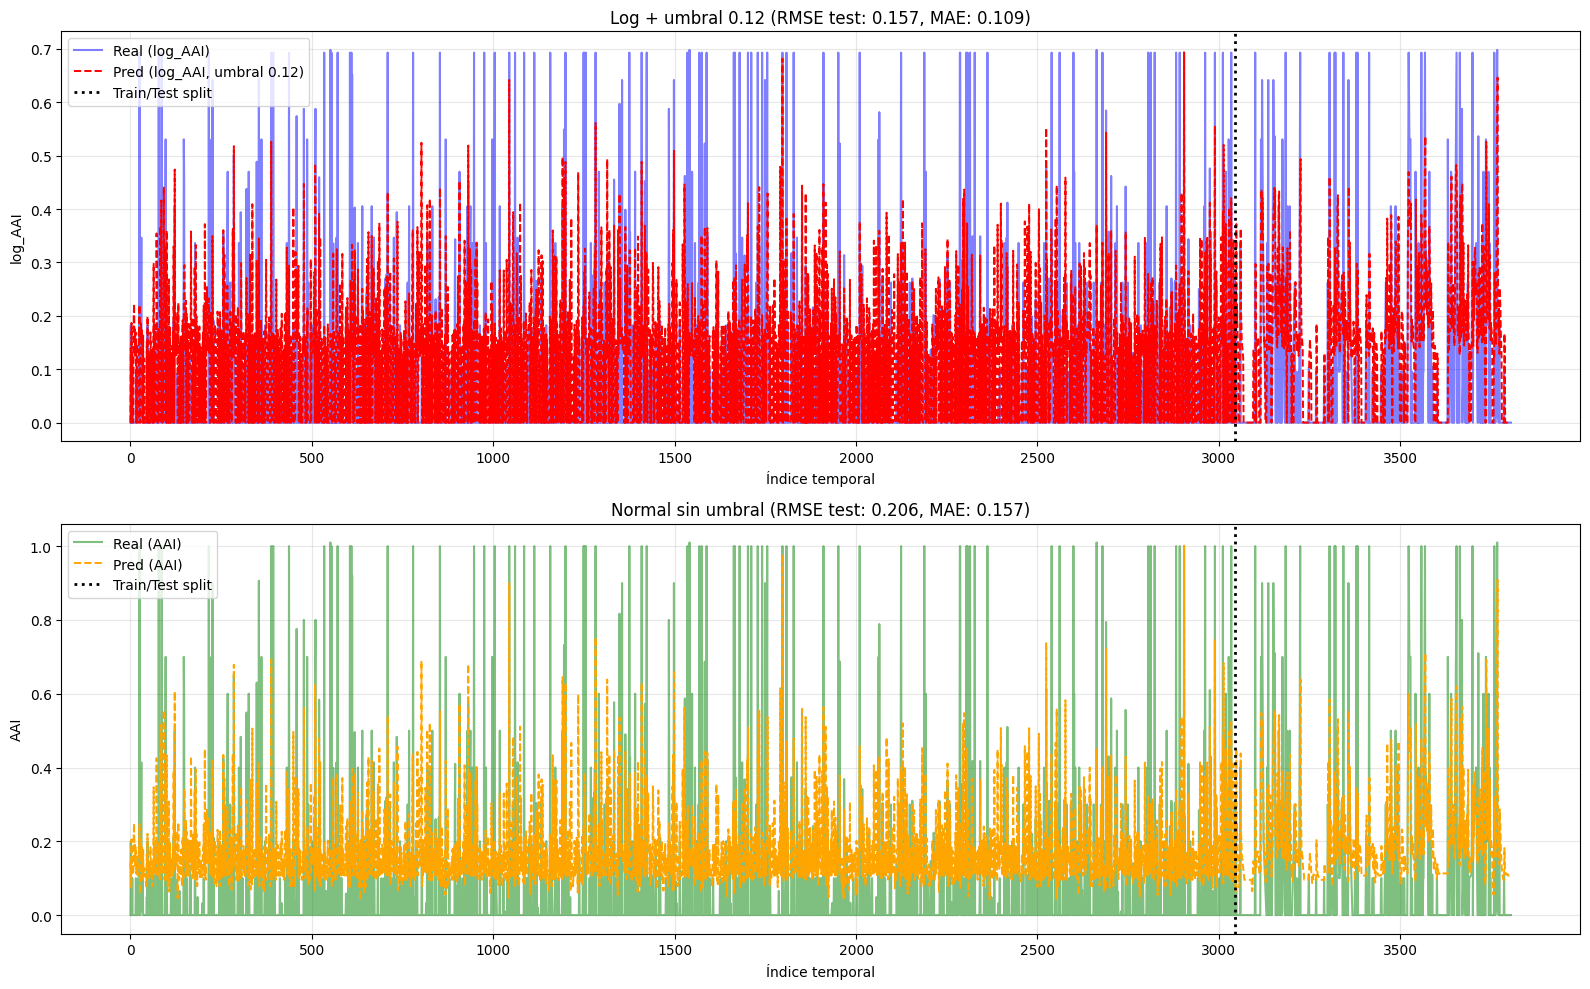

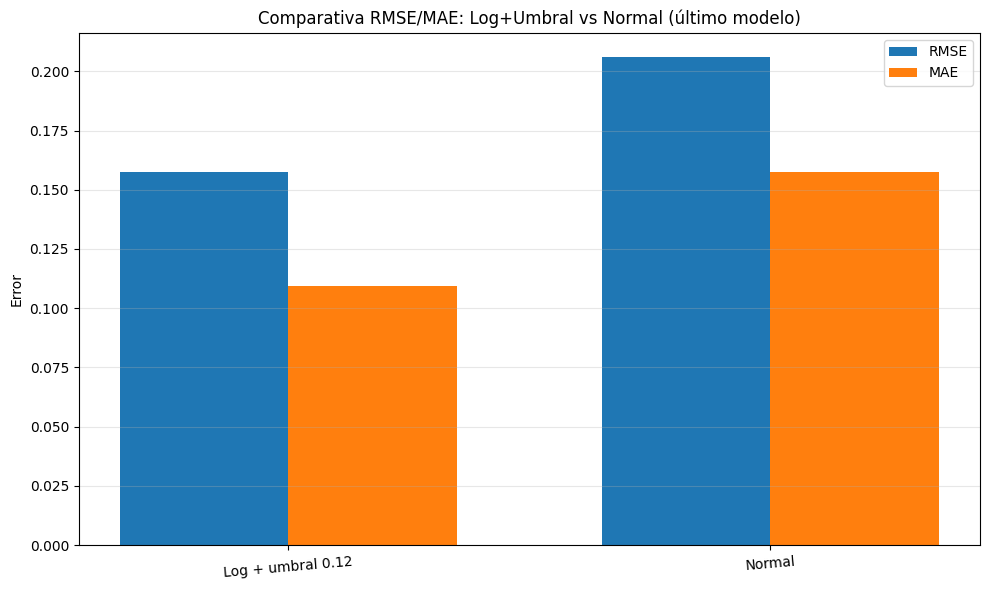

In [ ]:
# ==========================================
# GRÁFICAS (LOG+UMBRAL vs NORMAL) CON EL ÚLTIMO MODELO (OUTLIERS, 4 FEATURES)
# ==========================================

THRESHOLD = 0.12

# Verificar variables necesarias del último modelo (sección 3.1/3.2)
required_vars = ['all_predictions', 'all_actuals', 'scaler', 'features', 'train_size']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Faltan variables en memoria: {missing}. Ejecuta la sección 3.1 antes de esta celda.")

n_feat = len(features)

# Escala log (desescalada, sin expm1)
dummy_pred = np.zeros((len(all_predictions), n_feat))
dummy_pred[:, 0] = all_predictions.flatten()
all_pred_log = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_true = np.zeros((len(all_actuals), n_feat))
dummy_true[:, 0] = all_actuals.flatten()
all_true_log = scaler.inverse_transform(dummy_true)[:, 0]

# Escala normal (expm1)
all_pred_aai = np.expm1(all_pred_log)
all_true_aai = np.expm1(all_true_log)

# Umbral en log
all_pred_log_thr = all_pred_log.copy()
all_pred_log_thr[all_pred_log_thr < THRESHOLD] = 0.0

# Dividir train/test para métricas
train_cut = train_size
train_true_log = all_true_log[:train_cut]
test_true_log = all_true_log[train_cut:]
train_pred_log_thr = all_pred_log_thr[:train_cut]
test_pred_log_thr = all_pred_log_thr[train_cut:]

train_true_aai = all_true_aai[:train_cut]
test_true_aai = all_true_aai[train_cut:]
train_pred_aai = all_pred_aai[:train_cut]
test_pred_aai = all_pred_aai[train_cut:]

# Métricas
rmse_log_thr = np.sqrt(mean_squared_error(test_true_log, test_pred_log_thr))
mae_log_thr = mean_absolute_error(test_true_log, test_pred_log_thr)

rmse_norm = np.sqrt(mean_squared_error(test_true_aai, test_pred_aai))
mae_norm = mean_absolute_error(test_true_aai, test_pred_aai)

print(f"RMSE log (umbral 0.12): {rmse_log_thr:.4f} | MAE log: {mae_log_thr:.4f}")
print(f"RMSE normal (sin umbral): {rmse_norm:.4f} | MAE normal: {mae_norm:.4f}")

# Gráficas
idx = np.arange(len(all_true_log))
plt.figure(figsize=(16, 10))

# 1) Log + umbral
plt.subplot(2,1,1)
plt.plot(idx, all_true_log, label='Real (log_AAI)', color='blue', alpha=0.5)
plt.plot(idx, all_pred_log_thr, label='Pred (log_AAI, umbral 0.12)', color='red', linestyle='--', linewidth=1.4)
plt.axvline(x=train_cut, color='black', linestyle=':', linewidth=2, label='Train/Test split')
plt.title(f'Log + umbral 0.12 (RMSE test: {rmse_log_thr:.3f}, MAE: {mae_log_thr:.3f})')
plt.xlabel('Índice temporal')
plt.ylabel('log_AAI')
plt.legend()
plt.grid(True, alpha=0.3)

# 2) Normal sin umbral
plt.subplot(2,1,2)
plt.plot(idx, all_true_aai, label='Real (AAI)', color='green', alpha=0.5)
plt.plot(idx, all_pred_aai, label='Pred (AAI)', color='orange', linestyle='--', linewidth=1.4)
plt.axvline(x=train_cut, color='black', linestyle=':', linewidth=2, label='Train/Test split')
plt.title(f'Normal sin umbral (RMSE test: {rmse_norm:.3f}, MAE: {mae_norm:.3f})')
plt.xlabel('Índice temporal')
plt.ylabel('AAI')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('last_model_log_threshold_and_normal.png', dpi=300, bbox_inches='tight')
plt.show()

# Diagrama de barras comparativo
labels = ['Log + umbral 0.12', 'Normal']
rmse_vals = [rmse_log_thr, rmse_norm]
mae_vals = [mae_log_thr, mae_norm]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, rmse_vals, width, label='RMSE')
plt.bar(x + width/2, mae_vals, width, label='MAE')
plt.xticks(x, labels, rotation=5)
plt.ylabel('Error')
plt.title('Comparativa RMSE/MAE: Log+Umbral vs Normal (último modelo)')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('last_model_log_thr_vs_normal_bars.png', dpi=300, bbox_inches='tight')
plt.show()

# PARTE 5:  GENERALIZACIÓN EN UTAH(Alta-Collins)

- Convierte nieve de pulgadas a cm, crea una proxy de `log_aai` y `rolling_sum_3d`.
- Rellena `danger_level` y `mean_elev` con constantes (2 y 2000 m) para coincidir con las 4 columnas del modelo.
- Solo se hace `transform` con el scaler existente (no se hace fit).
- Se aplica umbral 0.12 en log y se muestran: gráfica log+umbral, gráfica normal, y barras de métricas usando la proxy como “ground truth”.

RMSE log (umbral 0.12): 1.1704 | MAE log: 0.5985
RMSE normal (sin umbral): 10.3500 | MAE normal: 3.9024


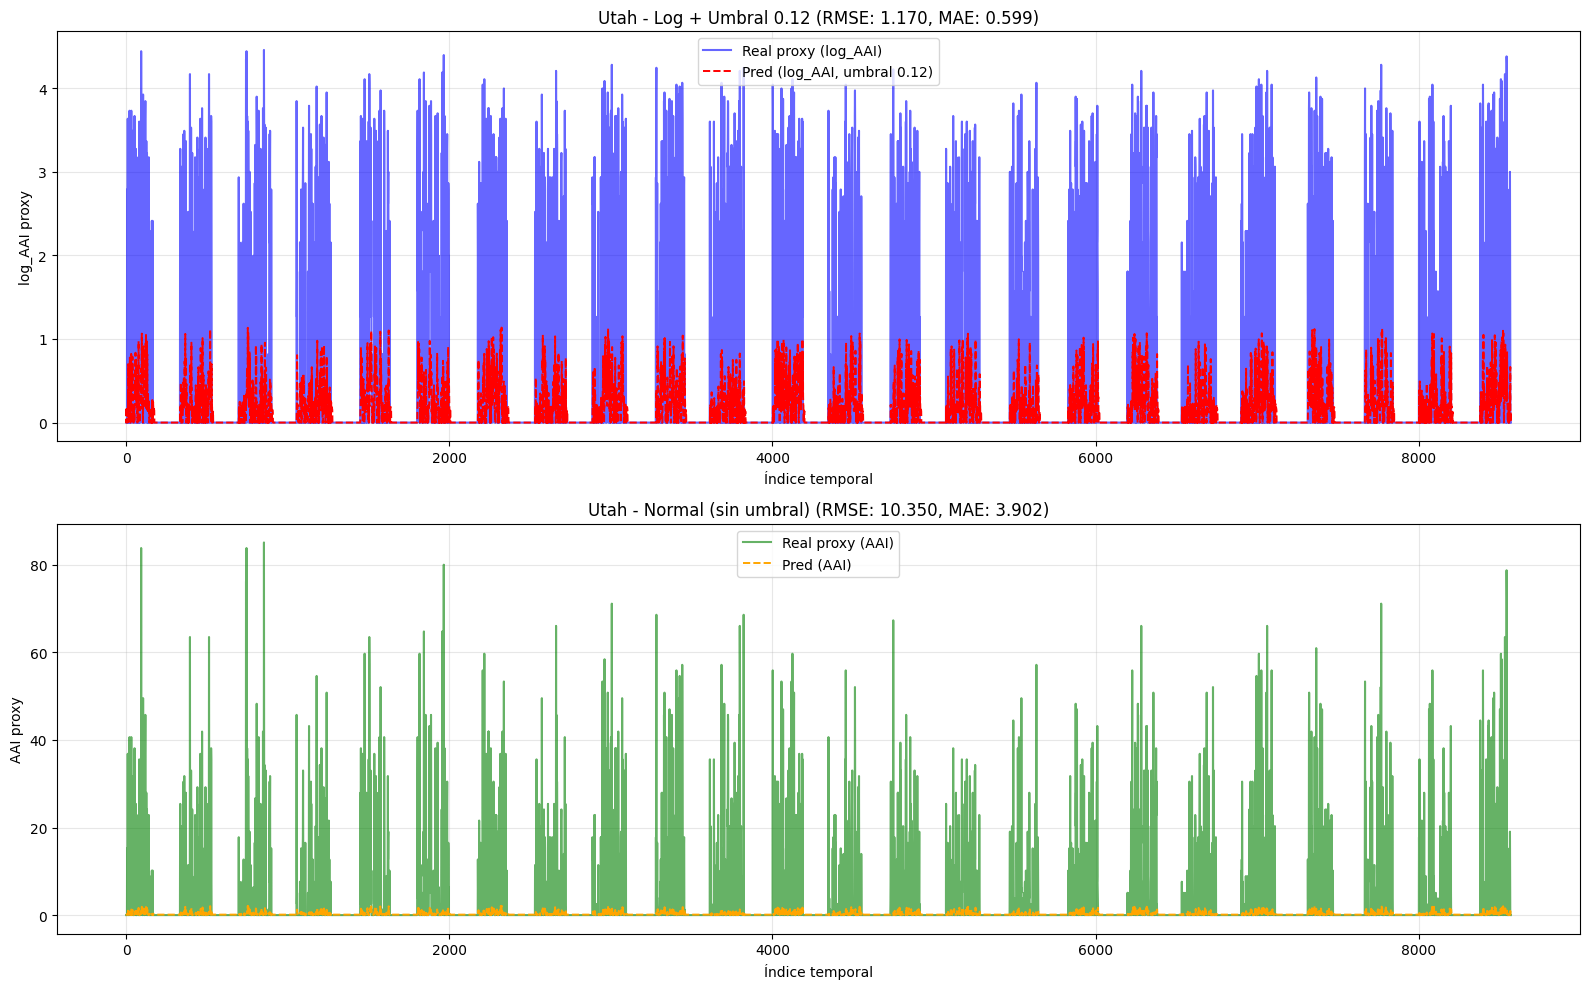

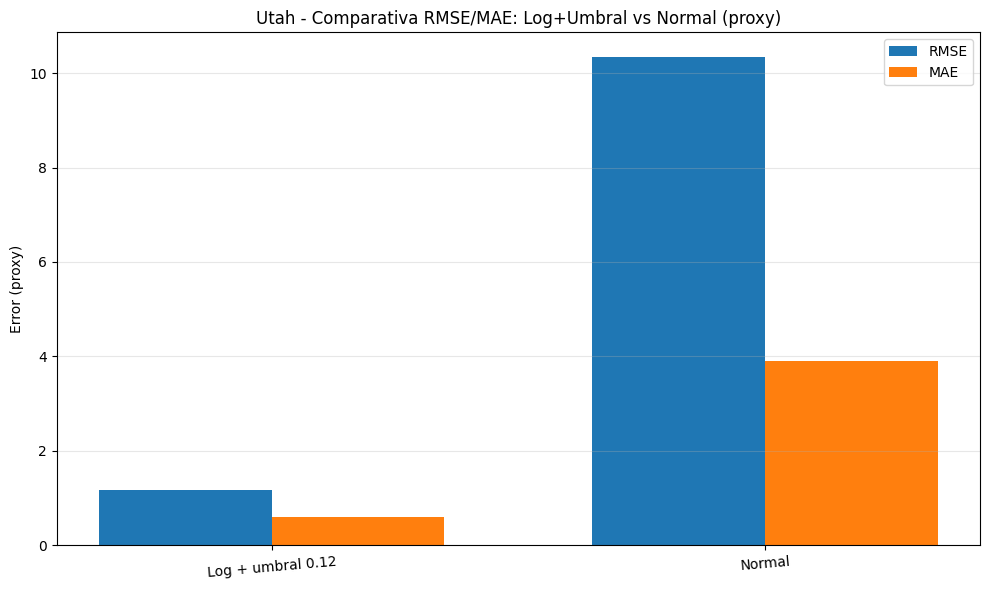

In [ ]:
# ==========================================
# GENERALIZACIÓN UTAH (ALTA-COLLINS)
# ==========================================

THRESHOLD = 0.12
FILE_PATH_UTAH = 'CLN_1999_2023_complete_v2.csv'

required_vars = ['model', 'scaler', 'features', 'train_size']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Faltan variables en memoria: {missing}. Ejecuta la sección 3.1 antes de esta celda.")

# Verificar que el modelo acepte 4 features
expected_in = getattr(getattr(model, 'lstm1', None), 'input_size', None)
if expected_in is not None and expected_in != 4:
    raise RuntimeError(f"El modelo en memoria no es el de 4 features (input_size={expected_in}). Recarga el último modelo (outliers).")

# Cargar datos de Utah
utah_df_raw = pd.read_csv(FILE_PATH_UTAH)

# Normalizar columnas
utah_df_raw.columns = [c.strip() for c in utah_df_raw.columns]
utah_df_raw.rename(columns={'Time (LST)': 'time', '12 hr Snow (in.)': 'snow_in', '12 hr LPE (in.)': 'lpe_in'}, inplace=True)

# Pasar a datetime y ordenar
utah_df_raw['time'] = pd.to_datetime(utah_df_raw['time'])
utah_df_raw = utah_df_raw.sort_values('time')

# Convertir a diario: sumatorio de nieve en 24h (dos registros de 12h)
utah_df_raw['snow_cm'] = utah_df_raw['snow_in'] * 2.54
utah_daily = utah_df_raw.set_index('time').resample('D').agg({
    'snow_cm': 'sum',
    'lpe_in': 'sum'
}).fillna(0).reset_index()

# Proxy de log_aai y rolling_sum_3d
utah_daily['log_aai'] = np.log1p(utah_daily['snow_cm'])
utah_daily['rolling_sum_3d'] = utah_daily['log_aai'].rolling(window=3).sum().fillna(0)

utah_daily['danger_level'] = 2.0
utah_daily['mean_elev'] = 2000.0

# Orden de columnas igual a 'features'
utah_features = utah_daily[features].copy()

# Transform con el scaler  (sin fit)
utah_scaled = scaler.transform(utah_features.values)

look_back = 10
X_utah, y_utah = create_dataset_multi(utah_scaled, look_back)

# Inferencia
model.eval()
with torch.no_grad():
    preds_utah_scaled = model(torch.tensor(X_utah, dtype=torch.float32).to(device)).cpu().numpy()

# Inversión a escala log
dummy_pred = np.zeros((len(preds_utah_scaled), len(features)))
dummy_pred[:, 0] = preds_utah_scaled.flatten()
utah_pred_log = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_true = np.zeros((len(y_utah), len(features)))
dummy_true[:, 0] = y_utah.flatten()
utah_true_log = scaler.inverse_transform(dummy_true)[:, 0]

# Escala normal
utah_pred_aai = np.expm1(utah_pred_log)
utah_true_aai = np.expm1(utah_true_log)

# Umbral en log
utah_pred_log_thr = utah_pred_log.copy()
utah_pred_log_thr[utah_pred_log_thr < THRESHOLD] = 0.0

# Métricas usando la proxy como “ground truth”
rmse_log_thr = np.sqrt(mean_squared_error(utah_true_log, utah_pred_log_thr))
mae_log_thr = mean_absolute_error(utah_true_log, utah_pred_log_thr)
rmse_norm = np.sqrt(mean_squared_error(utah_true_aai, utah_pred_aai))
mae_norm = mean_absolute_error(utah_true_aai, utah_pred_aai)

print(f"RMSE log (umbral 0.12): {rmse_log_thr:.4f} | MAE log: {mae_log_thr:.4f}")
print(f"RMSE normal (sin umbral): {rmse_norm:.4f} | MAE normal: {mae_norm:.4f}")

# Gráficas
idx = np.arange(len(utah_true_log))
plt.figure(figsize=(16, 10))

plt.subplot(2,1,1)
plt.plot(idx, utah_true_log, label='Real proxy (log_AAI)', color='blue', alpha=0.6)
plt.plot(idx, utah_pred_log_thr, label='Pred (log_AAI, umbral 0.12)', color='red', linestyle='--', linewidth=1.4)
plt.title(f'Utah - Log + Umbral 0.12 (RMSE: {rmse_log_thr:.3f}, MAE: {mae_log_thr:.3f})')
plt.xlabel('Índice temporal')
plt.ylabel('log_AAI proxy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2,1,2)
plt.plot(idx, utah_true_aai, label='Real proxy (AAI)', color='green', alpha=0.6)
plt.plot(idx, utah_pred_aai, label='Pred (AAI)', color='orange', linestyle='--', linewidth=1.4)
plt.title(f'Utah - Normal (sin umbral) (RMSE: {rmse_norm:.3f}, MAE: {mae_norm:.3f})')
plt.xlabel('Índice temporal')
plt.ylabel('AAI proxy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('utah_last_model_log_thr_and_normal.png', dpi=300, bbox_inches='tight')
plt.show()

# Barras comparativas
labels = ['Log + umbral 0.12', 'Normal']
rmse_vals = [rmse_log_thr, rmse_norm]
mae_vals = [mae_log_thr, mae_norm]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, rmse_vals, width, label='RMSE')
plt.bar(x + width/2, mae_vals, width, label='MAE')
plt.xticks(x, labels, rotation=5)
plt.ylabel('Error (proxy)')
plt.title('Utah - Comparativa RMSE/MAE: Log+Umbral vs Normal (proxy)')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('utah_last_model_log_thr_vs_normal_bars.png', dpi=300, bbox_inches='tight')
plt.show()

Factor de sensibilidad aplicado: 40.260
RMSE ajustada: 14.6528 | MAE ajustada: 9.3214


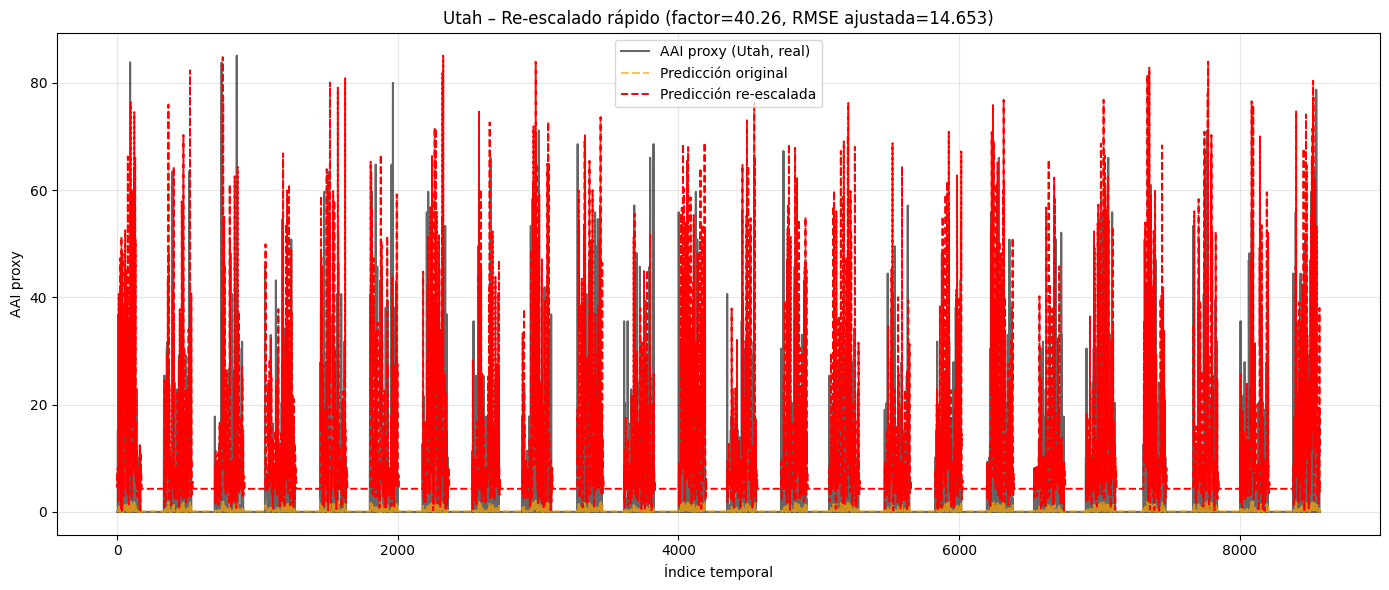

In [31]:
# ==========================================
# RE-ESCALADO RÁPIDO DE INFERENCIA (FACTOR GLOBAL) - UTAH
# ==========================================

pred_utah_orig = utah_pred_aai
data_real_utah = utah_true_aai 

# Evitar divisiones por cero
max_pred = np.max(pred_utah_orig)
max_real = np.max(data_real_utah)

if max_pred > 0 and max_real > 0:
    factor_sensibilidad = max_real / max_pred
else:
    factor_sensibilidad = 1.0  # por seguridad

print(f"Factor de sensibilidad aplicado: {factor_sensibilidad:.3f}")

# Predicción re-escalada
pred_utah_ajustada = pred_utah_orig * factor_sensibilidad

# Métricas con la serie ajustada
rmse_ajustada = np.sqrt(mean_squared_error(data_real_utah, pred_utah_ajustada))
mae_ajustada = mean_absolute_error(data_real_utah, pred_utah_ajustada)

print(f"RMSE ajustada: {rmse_ajustada:.4f} | MAE ajustada: {mae_ajustada:.4f}")

# Gráfico comparando original vs ajustada
plt.figure(figsize=(14, 6))
idx = np.arange(len(data_real_utah))
plt.plot(idx, data_real_utah, label='AAI proxy (Utah, real)', color='black', alpha=0.6)
plt.plot(idx, pred_utah_orig, label='Predicción original', color='orange', linestyle='--', alpha=0.7)
plt.plot(idx, pred_utah_ajustada, label='Predicción re-escalada', color='red', linestyle='--', linewidth=1.4)
plt.title(f'Utah – Re-escalado rápido (factor={factor_sensibilidad:.2f}, RMSE ajustada={rmse_ajustada:.3f})')
plt.xlabel('Índice temporal')
plt.ylabel('AAI proxy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('utah_last_model_rescaled.png', dpi=300, bbox_inches='tight')
plt.show()



## 5.1 Fine-Tuning del modelo suizo con datos de Utah

Tratamos de mantener la **capacidad de detección temporal** del modelo suizo y ajustar solo la **magnitud** para Utah de forma natural (sin trucos de multiplicación):

- Se parte del último modelo entrenado (outliers, 4 features) ya cargado en `model`.
- Se **congelan las capas LSTM** (`lstm1`, `lstm2`) que ya han aprendido a "leer" la nieve.
- Solo se afinan las capas finales (`fc1`, `fc2`) usando unos pocos días de Utah.
- Entrenamos **5 épocas** con un pequeño subconjunto de `X_utah, y_utah`.
- Después se compara la predicción original vs la del modelo afinado sobre todo Utah.


Iniciando fine-tuning en Utah (10 épocas, muestras usadas: 2000)...
Epoch 1/10 | Train Loss: 9.77803 | Val Loss: 9.32369
Epoch 2/10 | Train Loss: 9.81197 | Val Loss: 9.32407
Epoch 3/10 | Train Loss: 9.59025 | Val Loss: 9.32035
Epoch 4/10 | Train Loss: 9.64841 | Val Loss: 9.32435
Epoch 5/10 | Train Loss: 9.97638 | Val Loss: 9.32689
Epoch 6/10 | Train Loss: 9.55719 | Val Loss: 9.34091
Epoch 7/10 | Train Loss: 9.56239 | Val Loss: 9.34143
Epoch 8/10 | Train Loss: 9.66657 | Val Loss: 9.34724
Epoch 9/10 | Train Loss: 9.72923 | Val Loss: 9.35342
Epoch 10/10 | Train Loss: 9.78132 | Val Loss: 9.35374

Comparación antes vs después del fine-tuning (escala normal, proxy Utah):
  Original  | RMSE: 10.3500 | MAE: 3.9024
  Fine-tune | RMSE: 8.8367 | MAE: 4.9450


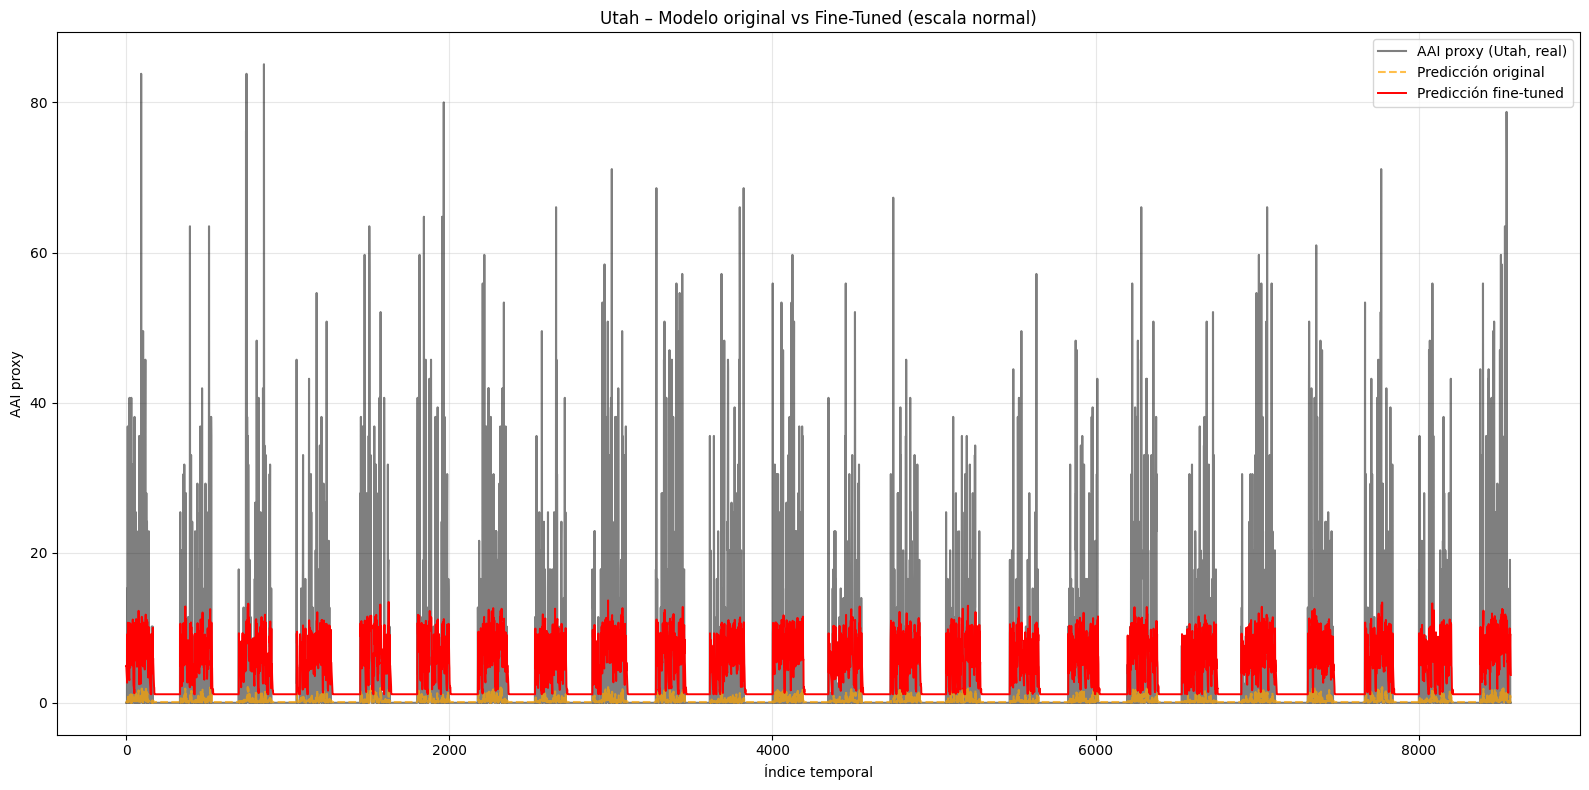

In [ ]:
# ==========================================
# FINE-TUNING DEL MODELO SUIZO CON DATOS DE UTAH
# ==========================================
required_vars_ft = ['model', 'X_utah', 'y_utah', 'scaler', 'features']
missing_ft = [v for v in required_vars_ft if v not in globals()]
if missing_ft:
    raise RuntimeError(f"Faltan variables para fine-tuning: {missing_ft}. Ejecuta la sección 3.1 y 3.4 antes de esta celda.")

for param in model.lstm1.parameters():
    param.requires_grad = False
for param in model.lstm2.parameters():
    param.requires_grad = False

max_samples = min(2000, len(X_utah))  
X_utah_ft = X_utah[:max_samples]
y_utah_ft = y_utah[:max_samples]

split_ft = int(len(X_utah_ft) * 0.8)
X_utah_train, X_utah_val = X_utah_ft[:split_ft], X_utah_ft[split_ft:]
y_utah_train, y_utah_val = y_utah_ft[:split_ft], y_utah_ft[split_ft:]

train_loader_utah = DataLoader(AvalancheDataset(X_utah_train, y_utah_train), batch_size=32, shuffle=True)
val_loader_utah = DataLoader(AvalancheDataset(X_utah_val, y_utah_val), batch_size=32, shuffle=False)

trainable_params = [p for p in model.fc1.parameters()] + [p for p in model.fc2.parameters()]
optimizer = torch.optim.Adam(trainable_params, lr=1e-4)

# Usamos la misma función de pérdida ponderada
n_epochs_ft = 10
print(f"Iniciando fine-tuning en Utah ({n_epochs_ft} épocas, muestras usadas: {len(X_utah_ft)})...")

for epoch in range(n_epochs_ft):
    model.train()
    train_losses_ft = []

    for X_batch, y_batch in train_loader_utah:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = weighted_mse_loss(y_pred, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=1.0)
        optimizer.step()

        train_losses_ft.append(loss.item())

    # Validación simple
    model.eval()
    val_losses_ft = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader_utah:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = weighted_mse_loss(y_pred, y_batch)
            val_losses_ft.append(loss.item())

    print(f"Epoch {epoch+1}/{n_epochs_ft} | Train Loss: {np.mean(train_losses_ft):.5f} | Val Loss: {np.mean(val_losses_ft):.5f}")

model.eval()
with torch.no_grad():
    preds_utah_ft_scaled = model(torch.tensor(X_utah, dtype=torch.float32).to(device)).cpu().numpy()

# Invertir a escala log y normal para comparar con la versión original
dummy_pred_ft = np.zeros((len(preds_utah_ft_scaled), len(features)))
dummy_pred_ft[:, 0] = preds_utah_ft_scaled.flatten()
utah_pred_log_ft = scaler.inverse_transform(dummy_pred_ft)[:, 0]
utah_pred_aai_ft = np.expm1(utah_pred_log_ft)

# Métricas en escala original usando la misma proxy utah_true_aai
rmse_norm_orig = np.sqrt(mean_squared_error(utah_true_aai, utah_pred_aai))
mae_norm_orig = mean_absolute_error(utah_true_aai, utah_pred_aai)
rmse_norm_ft = np.sqrt(mean_squared_error(utah_true_aai, utah_pred_aai_ft))
mae_norm_ft = mean_absolute_error(utah_true_aai, utah_pred_aai_ft)

print("\nComparación antes vs después del fine-tuning (escala normal, proxy Utah):")
print(f"  Original  | RMSE: {rmse_norm_orig:.4f} | MAE: {mae_norm_orig:.4f}")
print(f"  Fine-tune | RMSE: {rmse_norm_ft:.4f} | MAE: {mae_norm_ft:.4f}")

# Gráfica comparando original vs fine-tune
plt.figure(figsize=(16, 8))
idx = np.arange(len(utah_true_aai))
plt.plot(idx, utah_true_aai, label='AAI proxy (Utah, real)', color='black', alpha=0.5)
plt.plot(idx, utah_pred_aai, label='Predicción original', color='orange', linestyle='--', alpha=0.7)
plt.plot(idx, utah_pred_aai_ft, label='Predicción fine-tuned', color='red', linestyle='-', linewidth=1.4)
plt.title('Utah – Modelo original vs Fine-Tuned (escala normal)')
plt.xlabel('Índice temporal')
plt.ylabel('AAI proxy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('utah_last_model_finetuned_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# EVALUACION

## Baseline de Persistencia y Aciertos Críticos (modelo outliers LSTM)

En este apartado evaluamos el modelo LSTM con outliers limpiados frente a:
- **Baseline de persistencia**: Predicción(t) = Valor(t-1) en el conjunto de test.
- **Análisis de sensibilidad en colas**: solo días peligrosos donde `AAI_real > 0.5` y cuántos de ellos el modelo predice `AAI_predicho > 0.3`.

Esto permite demostrar que el modelo aprende más que la "inercia" y que es sensible a los eventos extremos importantes para protección civil/seguros.


RESULTADOS: PERSISTENCIA VS LSTM
Persistencia | RMSE: 6.8623 | MAE: 2.6476
LSTM Modelo  | RMSE: 5.5703 | MAE: 3.0019
Mejora LSTM  | ΔRMSE: 18.8% | ΔMAE: -13.4%


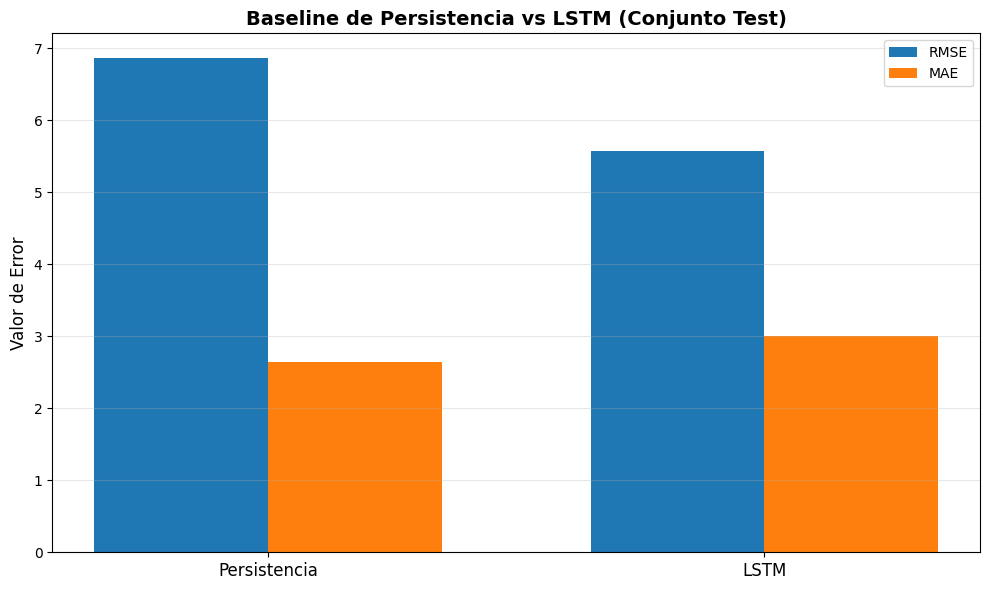


ANÁLISIS DE SEGURIDAD (EVENTOS EXTREMOS)
Días de Peligro Real (> 0.5): 211
Alertas Correctas (> 0.3):  211
Falsos Negativos (No detectados): 0
TASA DE ACIERTO (HIT RATE):       100.0%


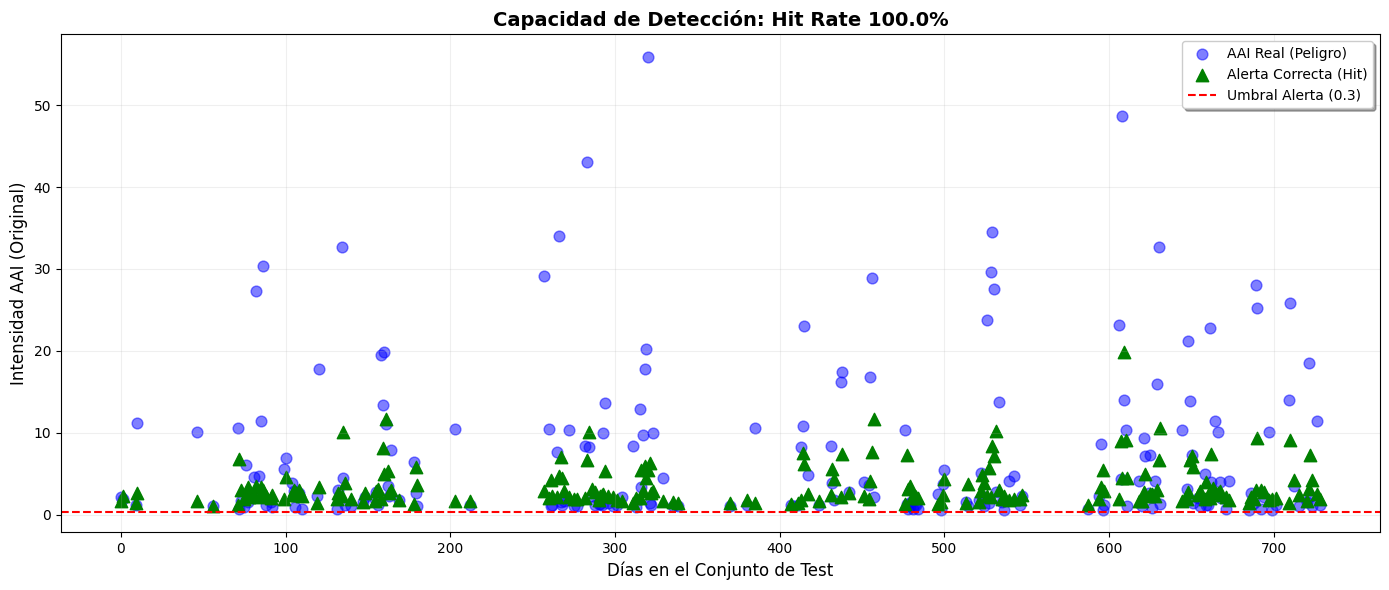

In [36]:
# ==========================================
# BASELINE DE PERSISTENCIA + ANÁLISIS DE ACIERTOS CRÍTICOS
# ==========================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Validación de variables en memoria
# Usamos las variables generadas en la sección de outliers (Parte 3)
required_vars = ['y_test_real', 'pred_test_real']
missing = [v for v in required_vars if v not in globals()]

if missing:
    # Intento de recuperación si los nombres varían en tu script
    if 'actuals_original' in globals() and 'predictions_original' in globals():
        y_test_real = actuals_original[train_size:]
        pred_test_real = predictions_original[train_size:]
    else:
        raise RuntimeError(f"Faltan variables: {missing}. Ejecuta primero la sección de evaluación.")

# ------------------------------------------
# PASO 1: Baseline de Persistencia (Naive Forecast)
# ------------------------------------------
# La persistencia asume que el valor de hoy es igual al de ayer: Pred(t) = Real(t-1)
y_true = y_test_real[1:]      # Valores reales desde el segundo día
y_persist = y_test_real[:-1]  # Valores de "ayer"
y_lstm = pred_test_real[1:]   # Predicciones de tu modelo alineadas

# Cálculo de métricas
rmse_persist = np.sqrt(mean_squared_error(y_true, y_persist))
mae_persist = mean_absolute_error(y_true, y_persist)

rmse_lstm = np.sqrt(mean_squared_error(y_true, y_lstm))
mae_lstm = mean_absolute_error(y_true, y_lstm)

# Mejora porcentual
improv_rmse = (rmse_persist - rmse_lstm) / rmse_persist * 100
improv_mae = (mae_persist - mae_lstm) / mae_persist * 100

print(f"{'='*50}")
print("RESULTADOS: PERSISTENCIA VS LSTM")
print(f"{'='*50}")
print(f"Persistencia | RMSE: {rmse_persist:.4f} | MAE: {mae_persist:.4f}")
print(f"LSTM Modelo  | RMSE: {rmse_lstm:.4f} | MAE: {mae_lstm:.4f}")
print(f"Mejora LSTM  | ΔRMSE: {improv_rmse:.1f}% | ΔMAE: {improv_mae:.1f}%")

# Gráfica de Barras
plt.figure(figsize=(10, 6))
labels = ['Persistencia', 'LSTM']
rmse_vals = [rmse_persist, rmse_lstm]
mae_vals = [mae_persist, mae_lstm]
x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, rmse_vals, width, label='RMSE', color='#1f77b4')
plt.bar(x + width/2, mae_vals, width, label='MAE', color='#ff7f0e')
plt.xticks(x, labels, fontsize=12)
plt.ylabel('Valor de Error', fontsize=12)
plt.title('Baseline de Persistencia vs LSTM (Conjunto Test)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('comparativa_persistencia.png', dpi=300)
plt.show()

# ------------------------------------------
# PASO 2: Gráfica de Aciertos Críticos (Sensibilidad)
# ------------------------------------------
# Definimos los umbrales de seguridad
crit_real_thr = 0.5   # Nivel real de avalanchas considerado peligroso
crit_pred_thr = 0.3   # Umbral de activación de alerta del modelo

mask_crit = y_test_real > crit_real_thr
idx_crit = np.where(mask_crit)[0]
n_crit = len(idx_crit)

if n_crit > 0:
    preds_on_crit = pred_test_real[idx_crit]
    hits_mask = preds_on_crit > crit_pred_thr
    n_hits = hits_mask.sum()
    hit_rate = (n_hits / n_crit) * 100

    print(f"\n{'='*50}")
    print("ANÁLISIS DE SEGURIDAD (EVENTOS EXTREMOS)")
    print(f"{'='*50}")
    print(f"Días de Peligro Real (> {crit_real_thr}): {n_crit}")
    print(f"Alertas Correctas (> {crit_pred_thr}):  {n_hits}")
    print(f"Falsos Negativos (No detectados): {n_crit - n_hits}")
    print(f"TASA DE ACIERTO (HIT RATE):       {hit_rate:.1f}%")

    # Gráfica de Dispersión de Aciertos
    plt.figure(figsize=(14, 6))
    plt.scatter(idx_crit, y_test_real[idx_crit], color='blue', s=60, label='AAI Real (Peligro)', alpha=0.5)
    
    # Identificar Hits y Misses
    hit_idx = idx_crit[hits_mask]
    miss_idx = idx_crit[~hits_mask]

    if len(hit_idx) > 0:
        plt.scatter(hit_idx, pred_test_real[hit_idx], color='green', marker='^', s=80, label='Alerta Correcta (Hit)')
    if len(miss_idx) > 0:
        plt.scatter(miss_idx, pred_test_real[miss_idx], color='red', marker='x', s=100, label='Alerta Fallida (Miss)')

    plt.axhline(crit_pred_thr, color='red', linestyle='--', linewidth=1.5, label=f'Umbral Alerta ({crit_pred_thr})')
    plt.xlabel('Días en el Conjunto de Test', fontsize=12)
    plt.ylabel('Intensidad AAI (Original)', fontsize=12)
    plt.title(f'Capacidad de Detección: Hit Rate {hit_rate:.1f}%', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.savefig('aciertos_criticos_sensibilidad.png', dpi=300)
    plt.show()
else:
    print("No se encontraron eventos críticos para el umbral seleccionado.")